In [38]:
import pandas as pd
import numpy as np

## DFs

In [7]:
df_de = pd.read_csv("events/new/events_dataframe_de.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_de['code'] = 'de'
df_en = pd.read_csv("events/new/events_dataframe_en.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_en['code'] = 'en'
df_it = pd.read_csv("events/new/events_dataframe_it.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_it['code'] = 'it'
df_es = pd.read_csv("events/new/events_dataframe_es.csv", converters={'redirects': pd.eval, 'list_views_7_days':pd.eval})
df_es['code'] = 'es'
df = pd.concat([df_en, df_de, df_it, df_es])
df.cat.replace({np.nan: 'undefined'}, inplace=True) # replace nan events
df = df[(df["views_7_sum"] != 0) & (df.cat != "")]
df.head(5)

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,surprising,factor,page_creation,edits_7_sum,edits_before_min,edits_before_mean,edits_before_max,edits_before_median,edits_before_sum,code
0,Q20514322,2015 Swedish Open,2015-07-01,Global North,Sweden,Europe,sports,"['Category:2015 ATP World Tour', 'Category:201...",2714,0.0,...,not_surprising,before,2015-06-20T21:48:47Z,6,0,0.0,0,0.0,0,en
1,Q20635386,2015 Chama Cha Mapinduzi presidential primaries,2015-07-01,Global South,Tanzania,Africa,politics,"['Category:2015 elections in Tanzania', 'Categ...",1069,0.0,...,not_surprising,before,2015-06-30T04:00:05Z,39,0,0.0,0,0.0,0,en
2,Q20639899,2015 Ji'an bus accident,2015-07-01,Global South,China,Asia,disaster,"['Category:2015 disasters in China', 'Category...",1161,0.0,...,surprising,surprising,2015-07-02T04:59:36Z,40,0,0.0,0,0.0,0,en
3,Q17020570,2023 South Sudanese general election,2015-07-01,Global South,South Sudan,Africa,politics,"['Category:2023 elections in Africa', 'Categor...",166,0.0,...,not_surprising,before,2013-07-28T20:05:12Z,0,0,0.0,0,0.0,0,en
4,Q20646862,Aleppo offensive (July 2015),2015-07-02,Global South,Syria,Asia,politics,"['Category:Aleppo in the Syrian civil war', 'C...",2372,0.0,...,not_surprising,after,2015-07-07T16:48:02Z,12,0,0.0,0,0.0,0,en


In [ ]:
# quick save for retrieval
np.savetxt('scraping/scripts/en_articles.txt', df[df.code=='en'].pagetitle.unique(), fmt='%s')
np.savetxt('scraping/scripts/es_articles.txt', df[df.code=='es'].pagetitle.unique(), fmt='%s')
np.savetxt('scraping/scripts/de_articles.txt', df[df.code=='it'].pagetitle.unique(), fmt='%s')
np.savetxt('scraping/scripts/de_articles.txt', df[df.code=='de'].pagetitle.unique(), fmt='%s')

In [ ]:
np.savetxt('scraping/scripts/es_articles_corrected.txt', df[(df.code=='es') & df.pagetitle.str.startswith('Anexo:')].pagetitle.str.replace('Anexo:', '').unique(), fmt='%s')

## Bing results

In [8]:
import json
import re

def load_json_files(files):
    data = {}
    for file in files:
        with open(f'{file}') as json_data:
            data = {**data, **json.load(json_data)}
            print(f'LOAD FROM {file}, Articles now: {len(data)}')
    return data

def get_hits_from_json(json_data, serp='bing'):
    bing_news_hits = []
    i = 0 
    for title, crawl_res in json_data.items():
        # get result string and clean
        if '1' not in crawl_res:
            print(f'Error in results for {title}: |{crawl_res}|')
            continue
    
        res_string = crawl_res['1']['num_results']
        num_string = re.sub('[^0-9]', '', res_string)
        
        if len(num_string) == 0:
            print(f'Error when parsing hits for {title}: |{res_string}|')
            continue

        bing_news_hits.append([title, int(num_string)])
        
        # debug output
        #if i%500 == 0:
        #    print(title, res_string, num_string)
        #i+=1
    return pd.DataFrame(bing_news_hits, columns=['pagetitle', f'{serp}_hits'])

def load_lang_news_hits(lang_files: dict, serp='bing'):
    df_langs = []
    for lang, files in lang_files.items():
        print(f'Loading {lang}')
        json_data = load_json_files(files)
        df_hits = get_hits_from_json(json_data, serp)
        df_hits['code'] = lang
        df_langs.append(df_hits)

    return pd.concat(df_langs)

In [9]:
files_en = ['scraping/results/en_bingnews.json', 'scraping/results/en_bingnews_rest.json', 'scraping/results/en_bingnews_missing.json']
files_de = ['scraping/results/de_bingnews.json', 'scraping/results/de_bingnews_missing.json']
files_it = ['scraping/results/it_bingnews.json', 'scraping/results/it_bingnews_missing.json']
files_es = ['scraping/results/es_bingnews_es-ES.json', 'scraping/results/es_bingnews_es-ES_missing.json']

df_news = load_lang_news_hits({'de': files_de, 'en': files_en, 'it': files_it, 'es': files_es})
df_news.head()

Loading de
LOAD FROM scraping/results/de_bingnews.json, Articles now: 2304
LOAD FROM scraping/results/de_bingnews_missing.json, Articles now: 2376
Loading en
LOAD FROM scraping/results/en_bingnews.json, Articles now: 5262
LOAD FROM scraping/results/en_bingnews_rest.json, Articles now: 7761
LOAD FROM scraping/results/en_bingnews_missing.json, Articles now: 7761
Loading it
LOAD FROM scraping/results/it_bingnews.json, Articles now: 2297
LOAD FROM scraping/results/it_bingnews_missing.json, Articles now: 2358
Loading es
LOAD FROM scraping/results/es_bingnews_es-ES.json, Articles now: 3253
LOAD FROM scraping/results/es_bingnews_es-ES_missing.json, Articles now: 3448


,pagetitle,bing_hits,code
0,Griechisches Referendum 2015,50,de
1,Großer Preis von Großbritannien 2015,4560,de
2,Distal & ITR Group Tennis Cup 2015,2,de
3,Reinert Open 2015,0,de
4,CONCACAF Gold Cup 2015,10,de


In [10]:
df_es_corrected = load_lang_news_hits({'es': ['scraping/results/es_bingnews_es-ES_corrected.json']})
df_es_corrected['pagetitle_original'] = df_es_corrected.pagetitle.apply(lambda s: 'Anexo:' + str(s))
# this could be nicer, but writing this code was easier.
df_news.loc[:, 'bing_hits'] = df_news.apply(lambda row: df_es_corrected[df_es_corrected.pagetitle_original==row.pagetitle].bing_hits.values[0] if row.pagetitle.startswith('Anexo:') else row.bing_hits, axis=1)
df_news

Loading es
LOAD FROM scraping/results/es_bingnews_es-ES_corrected.json, Articles now: 552


,pagetitle,bing_hits,code
0,Griechisches Referendum 2015,50,de
1,Großer Preis von Großbritannien 2015,4560,de
2,Distal & ITR Group Tennis Cup 2015,2,de
3,Reinert Open 2015,0,de
4,CONCACAF Gold Cup 2015,10,de
...,...,...,...
3443,Elecciones generales de Níger de 2020-2021,307000,es
3444,Elecciones generales de la República Centroafr...,51800,es
3445,Terremoto de Petrinja de 2020,28,es
3446,Avalancha de Gjerdrum de 2020,14400,es


In [62]:
# only run this if you are sure something's missing
df_crawled = df.merge(df_news, on=['pagetitle', 'code'], how='outer')
df_missing = df_crawled[pd.isna(df_crawled.bing_hits)]
np.savetxt('scraping/scripts/en_articles_missing.txt', df_missing[df_missing.code=='en'].pagetitle.unique(), fmt='%s')
np.savetxt('scraping/scripts/de_articles_missing.txt', df_missing[df_missing.code=='de'].pagetitle.unique(), fmt='%s')
np.savetxt('scraping/scripts/it_articles_missing.txt', df_missing[df_missing.code=='it'].pagetitle.unique(), fmt='%s')
np.savetxt('scraping/scripts/es_articles_missing.txt', df_missing[df_missing.code=='es'].pagetitle.unique(), fmt='%s')

In [11]:
# show article counts
print('de', len(df_news[df_news.code=='de']), len(df[df.code=='de']))
print('it', len(df_news[df_news.code=='it']), len(df[df.code=='it']))
print('es', len(df_news[df_news.code=='es']), len(df[df.code=='es']))
print('en', len(df_news[df_news.code=='en']), len(df[df.code=='en']))
print('total', len(df), len(df_news))

# check duplicates
df_crawled = df.merge(df_news, on=['pagetitle', 'code'], how='outer')
df_crawled = df_crawled.loc[~pd.isna(df_crawled.bing_hits)]
print(f'With duplicates, but dropped na from bing {len(df_crawled)}')
df_crawled = df_crawled.loc[~df_crawled.pagetitle.duplicated(keep=False), :]
print(f'Without duplicates {len(df_crawled)}')
print('de', len(df_crawled[df_crawled.code=='de']))
print('it', len(df_crawled[df_crawled.code=='it']))
print('es', len(df_crawled[df_crawled.code=='es']))
print('en', len(df_crawled[df_crawled.code=='en']))
df_crawled

de 2376 2502
it 2358 2470
es 3448 3587
en 7761 8021
total 16580 15943
With duplicates, but dropped na from bing 16580
Without duplicates 14198
de 1994
it 1804
es 3051
en 7349


,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,factor,page_creation,edits_7_sum,edits_before_min,edits_before_mean,edits_before_max,edits_before_median,edits_before_sum,code,bing_hits
0,Q20514322,2015 Swedish Open,2015-07-01,Global North,Sweden,Europe,sports,"['Category:2015 ATP World Tour', 'Category:201...",2714,0.000000,...,before,2015-06-20T21:48:47Z,6,0,0.000000,0,0.0,0,en,180000
1,Q20635386,2015 Chama Cha Mapinduzi presidential primaries,2015-07-01,Global South,Tanzania,Africa,politics,"['Category:2015 elections in Tanzania', 'Categ...",1069,0.000000,...,before,2015-06-30T04:00:05Z,39,0,0.000000,0,0.0,0,en,32
2,Q20639899,2015 Ji'an bus accident,2015-07-01,Global South,China,Asia,disaster,"['Category:2015 disasters in China', 'Category...",1161,0.000000,...,surprising,2015-07-02T04:59:36Z,40,0,0.000000,0,0.0,0,en,37600
5,Q20646862,Aleppo offensive (July 2015),2015-07-02,Global South,Syria,Asia,politics,"['Category:Aleppo in the Syrian civil war', 'C...",2372,0.000000,...,after,2015-07-07T16:48:02Z,12,0,0.000000,0,0.0,0,en,28800
6,Q15699191,2015–16 UEFA Europa League,2015-07-02,Global North,Spain,Europe,sports,"['Category:2015–16 UEFA Europa League', 'Categ...",83545,10905.000000,...,before,2013-05-24T16:29:04Z,13,0,1.833333,6,1.0,11,en,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16575,Q85736512,Elecciones generales de Níger de 2020-2021,2020-12-27,Global South,Niger,Africa,politics,"['Categoría:Elecciones en Níger', 'Categoría:E...",1526,0.000000,...,before,2020-12-02T16:21:11Z,0,0,0.000000,0,0.0,0,es,307000
16576,Q96350674,Elecciones generales de la República Centroafr...,2020-12-27,Global South,Central African Republic,Africa,politics,['Categoría:Elecciones en República Centroafri...,1520,103.142857,...,before,2020-12-02T17:51:35Z,5,0,0.000000,0,0.0,0,es,51800
16577,Q104535090,Terremoto de Petrinja de 2020,2020-12-29,Global North,Croatia,Europe,undefined,"['Categoría:Croacia en 2020', 'Categoría:Terre...",654,0.000000,...,surprising,2020-12-30T22:34:35Z,10,0,0.000000,0,0.0,0,es,28
16578,Q104579536,Avalancha de Gjerdrum de 2020,2020-12-30,Global North,Norway,Europe,disaster,"['Categoría:Corrimientos de tierra', 'Categorí...",24,0.000000,...,after,2021-01-05T23:09:16Z,0,0,0.000000,0,0.0,0,es,14400


# Merge with GDP

In [12]:
gdp_all = pd.read_csv('gdp/gdp_all.csv')
df_crawled.country.replace({'Republic of the Congo': 'Democratic Republic of the Congo'}, inplace=True)
df_crawled = df_crawled.merge(gdp_all[['Country/Area', 'Year', 'GDP_pc', 'GDP', 'oecd']], left_on=['country', 'year'], right_on=['Country/Area', 'Year'], how='left', copy=True)
df_crawled

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,edits_before_max,edits_before_median,edits_before_sum,code,bing_hits,Country/Area,Year,GDP_pc,GDP,oecd
0,Q20514322,2015 Swedish Open,2015-07-01,Global North,Sweden,Europe,sports,"['Category:2015 ATP World Tour', 'Category:201...",2714,0.000000,...,0,0.0,0,en,180000,Sweden,2015.0,51726.202525,5.051038e+11,True
1,Q20635386,2015 Chama Cha Mapinduzi presidential primaries,2015-07-01,Global South,Tanzania,Africa,politics,"['Category:2015 elections in Tanzania', 'Categ...",1069,0.000000,...,0,0.0,0,en,32,Tanzania,2015.0,946.787110,4.737860e+10,False
2,Q20639899,2015 Ji'an bus accident,2015-07-01,Global South,China,Asia,disaster,"['Category:2015 disasters in China', 'Category...",1161,0.000000,...,0,0.0,0,en,37600,China,2015.0,7862.662292,1.106157e+13,False
3,Q20646862,Aleppo offensive (July 2015),2015-07-02,Global South,Syria,Asia,politics,"['Category:Aleppo in the Syrian civil war', 'C...",2372,0.000000,...,0,0.0,0,en,28800,Syria,2015.0,1109.412836,1.996656e+10,False
4,Q15699191,2015–16 UEFA Europa League,2015-07-02,Global North,Spain,Europe,sports,"['Category:2015–16 UEFA Europa League', 'Categ...",83545,10905.000000,...,6,1.0,11,en,249,Spain,2015.0,25606.812754,1.195119e+12,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14193,Q85736512,Elecciones generales de Níger de 2020-2021,2020-12-27,Global South,Niger,Africa,politics,"['Categoría:Elecciones en Níger', 'Categoría:E...",1526,0.000000,...,0,0.0,0,es,307000,Niger,2020.0,567.669697,1.374138e+10,False
14194,Q96350674,Elecciones generales de la República Centroafr...,2020-12-27,Global South,Central African Republic,Africa,politics,['Categoría:Elecciones en República Centroafri...,1520,103.142857,...,0,0.0,0,es,51800,Central African Republic,2020.0,481.016462,2.323197e+09,False
14195,Q104535090,Terremoto de Petrinja de 2020,2020-12-29,Global North,Croatia,Europe,undefined,"['Categoría:Croacia en 2020', 'Categoría:Terre...",654,0.000000,...,0,0.0,0,es,28,Croatia,2020.0,13934.241955,5.720378e+10,False
14196,Q104579536,Avalancha de Gjerdrum de 2020,2020-12-30,Global North,Norway,Europe,disaster,"['Categoría:Corrimientos de tierra', 'Categorí...",24,0.000000,...,0,0.0,0,es,14400,Norway,2020.0,66870.730726,3.625223e+11,True


In [13]:
# these are the countries/places without gdp data in my dataframe
df_crawled[df_crawled.country.isin(df_crawled[pd.isna(df_crawled.Year)].country.unique())].country.unique()

array(['Taiwan', 'Faroe Islands', 'Cape Verde', 'Guernsey',
       'Sint Maarten', 'Niue', 'Falkland Islands', 'Gibraltar',
       'Vatican City'], dtype=object)

In [14]:
df_crawled = df_crawled[~df_crawled.country.isin(df_crawled[pd.isna(df_crawled.Year)].country.unique())]
print('Actually remaining datapoints:', len(df_crawled))

Actually remaining datapoints: 14088


# Merge with gni

In [168]:
gni = pd.read_csv('worldbank/gni_export.csv', sep=',', encoding='latin3')
gni = gni.drop(['code'], axis=1).set_index('name')
gni = gni.unstack(fill_value='..').reset_index().rename({'level_0': 'year', 'name': 'country', 0: 'gni_class'}, axis=1)
gni.year = gni.year.astype(int)

In [415]:
gni

,year,country,gni_class
0,1987,Afghanistan,L
1,1987,Albania,..
2,1987,Algeria,UM
3,1987,American Samoa,H
4,1987,Andorra,..
...,...,...,...
7407,2020,Virgin Islands (U.S.),H
7408,2020,West Bank and Gaza,LM
7409,2020,Yemen,L
7410,2020,Zambia,LM


In [169]:
gni.country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'Colombia', 'Comoros', 'Democratic Republic of the Congo',
       'Congo, Rep.', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba',
       'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Faeroe I

In [156]:
df_crawled = df_crawled[df_crawled.columns[:-1]].merge(gni, on=['country', 'year'], how='left')

In [172]:
print('Missing', len(df_crawled[pd.isna(df_crawled.gni_class)]))

Missing 13


In [175]:
df_crawled[pd.isna(df_crawled.gni_class)].country.unique()

array(['Saint Lucia', 'São Tomé and Príncipe',
       'Federated States of Micronesia', 'Cook Islands',
       'Saint Kitts and Nevis'], dtype=object)

In [176]:
df_crawled = df_crawled[~pd.isna(df_crawled.gni_class)]

## Regional Groups 

https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups

In [237]:
regional_class = pd.read_csv('worldbank/economies_class.csv', sep=';', encoding='latin1')
#regional_groups.rename({'GroupName': 'gni_region', 'CountryName': 'country'}, axis=1, inplace=True)
regional_class.head()

,Economy,Code,Region,Income group,Lending category,Other (EMU or HIPC)
0,Aruba,ABW,Latin America & Caribbean,High income,NaN,NaN
1,Afghanistan,AFG,South Asia,Low income,IDA,HIPC
2,Angola,AGO,Sub-Saharan Africa,Lower middle income,IBRD,NaN
3,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,NaN
4,Andorra,AND,Europe & Central Asia,High income,NaN,NaN


In [450]:
replace_dict = {
 'Bahamas, The': 'Bahamas',
 'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
 'Egypt, Arab Rep.': 'Egypt',
 'Faroe Islands': 'Faeroe Islands',
 'Gambia, The': 'Gambia',
 'Hong Kong SAR, China': 'Hong Kong',
 'Iran, Islamic Rep.': 'Iran',
 "Korea, Dem. People's Rep.": 'North Korea',
 'Korea, Rep.': 'South Korea',
 'Kyrgyz Republic': 'Kyrgyzstan',
 'Lao PDR': 'Laos',
 'Micronesia, Fed. Sts.': 'Federated States of Micronesia',
 'North Macedonia': 'Macedonia',
 'Russian Federation': 'Russia',
 'S?o Tomé and Principe': 'São Tomé and Príncipe',
 'Slovak Republic': 'Slovakia',
 'St. Kitts and Nevis': 'Saint Kitts and Nevis',
 'St. Lucia': 'Saint Lucia',
 'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
 'Syrian Arab Republic': 'Syria',
 'Venezuela, RB': 'Venezuela',
 'Yemen, Rep.': 'Yemen',
 'Curacao': 'Curaçao',
 "Cote d'Ivoire": "Côte d'Ivoire"
}


In [ ]:
regional_class.replace(replace_dict, inplace=True)
regional_class = regional_class[~pd.isna(regional_class.Region)].rename({'Economy': 'country', 'Region': 'gni_region', 'Income group': 'gni_group'}, axis=1)
regional_class.head()

In [241]:
df_crawled = df_crawled.merge(regional_class[['country', 'gni_region']], on='country', how='left')

In [246]:
df_crawled.gni_region.unique()

array(['Europe & Central Asia', 'Sub-Saharan Africa',
       'East Asia & Pacific', 'Middle East & North Africa',
       'North America', 'Latin America & Caribbean', 'South Asia'],
      dtype=object)

# Merge with population

In [456]:
df_population = pd.read_csv('worldbank/population/population.csv', sep=';')
df_population = df_population.set_index('Country Name')
df_population = df_population[['2014', '2015', '2016', '2017', '2018', '2019', '2020']]
df_population = df_population.unstack().reset_index().rename({'Country Name': 'country', 'level_0': 'year', 0: 'population'}, axis=1)
df_population.replace(replace_dict, inplace=True)

In [455]:
df_crawled = df_crawled[df_crawled.columns[:-2]]

In [457]:
df_population = df_population.dropna()
df_population.year = df_population.year.astype(int)
df_population.population = df_population.population.astype(int)
df_crawled = df_crawled.merge(df_population, on=['country', 'year'], how='left')
df_crawled.head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,gni_class,gni_region,population
0,Q20514322,2015 Swedish Open,2015-07-01,Global North,Sweden,Europe,sports,"['Category:2015 ATP World Tour', 'Category:201...",2714,0.0,...,Sweden,2015.0,51726.202525,5.051038e+11,True,False,False,H,Europe & Central Asia,9799186
1,Q20635386,2015 Chama Cha Mapinduzi presidential primaries,2015-07-01,Global South,Tanzania,Africa,politics,"['Category:2015 elections in Tanzania', 'Categ...",1069,0.0,...,Tanzania,2015.0,946.787110,4.737860e+10,False,True,False,L,Sub-Saharan Africa,51482638
2,Q20639899,2015 Ji'an bus accident,2015-07-01,Global South,China,Asia,disaster,"['Category:2015 disasters in China', 'Category...",1161,0.0,...,China,2015.0,7862.662292,1.106157e+13,False,False,False,UM,East Asia & Pacific,1379860000
3,Q20646862,Aleppo offensive (July 2015),2015-07-02,Global South,Syria,Asia,politics,"['Category:Aleppo in the Syrian civil war', 'C...",2372,0.0,...,Syria,2015.0,1109.412836,1.996656e+10,False,False,False,LM,Middle East & North Africa,17997411
4,Q15699191,2015–16 UEFA Europa League,2015-07-02,Global North,Spain,Europe,sports,"['Category:2015–16 UEFA Europa League', 'Categ...",83545,10905.0,...,Spain,2015.0,25606.812754,1.195119e+12,True,False,False,H,Europe & Central Asia,46444832


# Investigate data

In [15]:
import matplotlib.pyplot as plt

In [16]:
def plot_cat_by_cat(df_inv, col_vis, col_plot, lang=('de', 'en', 'it', 'es'), figsize=(20, 4)):
    for lang in lang:
        values_col_plot = df_inv[col_plot].unique()
        fig, ax = plt.subplots(nrows=1, ncols=len(values_col_plot), figsize=figsize)
        fig.suptitle(f'{lang}: {col_vis} by {col_plot}')
        axs = ax.flatten()

        for i, val in enumerate(values_col_plot):
            df_plt  = df_inv[(df_inv.code==lang) & (df_inv[col_plot] == val)]

            if len(df_plt) == 0:
                continue

            col_vis_count = df_plt.groupby(col_vis).count()['views_7_sum']
            col_vis_count.plot.bar(ax=axs[i], sharex=True, sharey=False)
            axs[i].set_title(f'{val} ({col_vis_count.sum()} articles)')

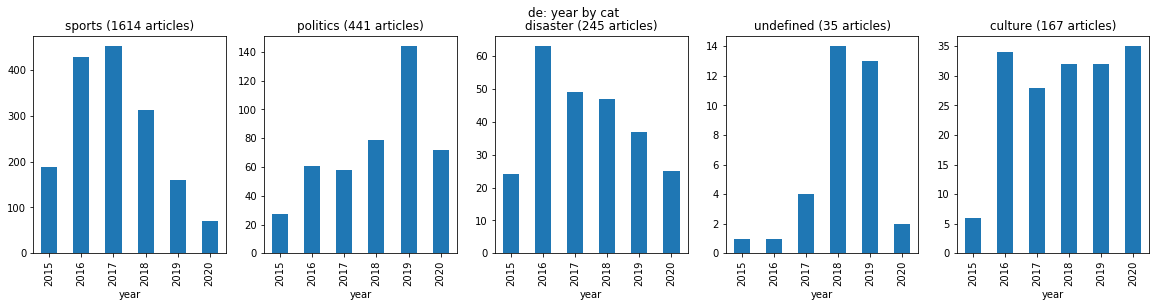

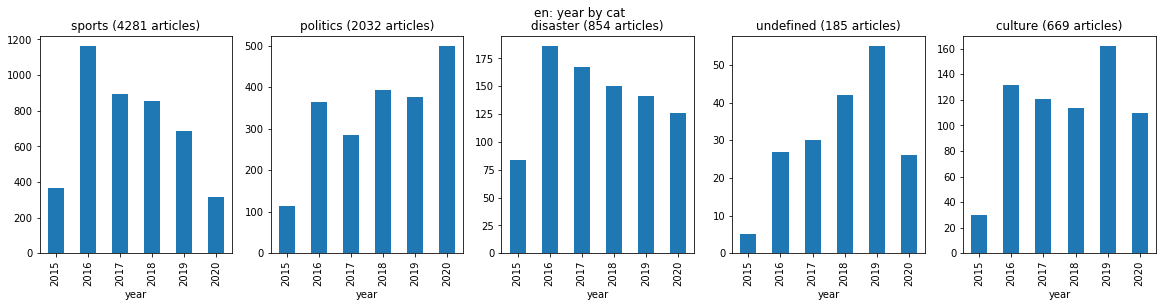

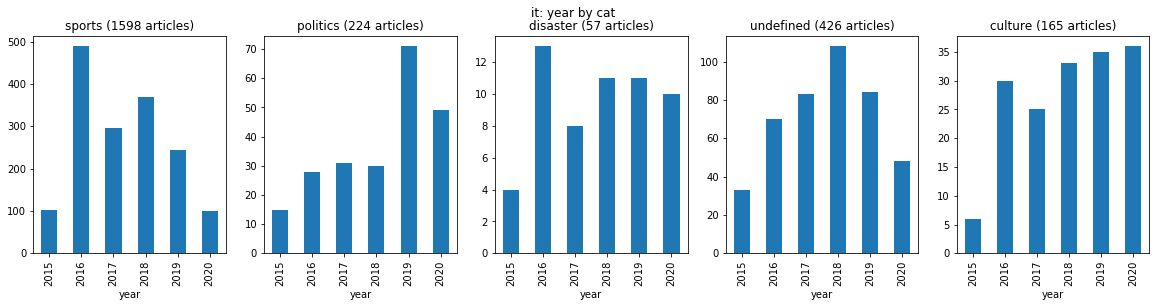

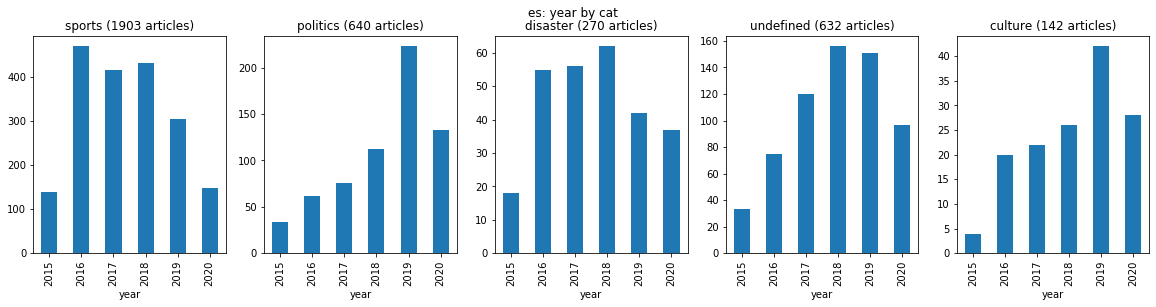

In [18]:
plot_cat_by_cat(df, 'year', 'cat', figsize=(20,4))

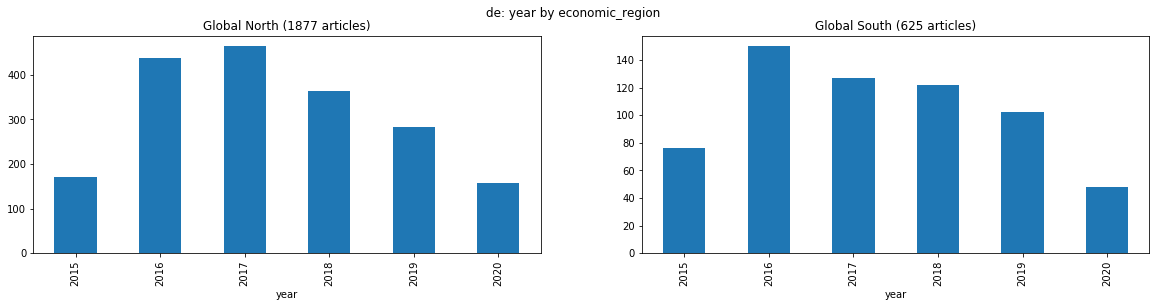

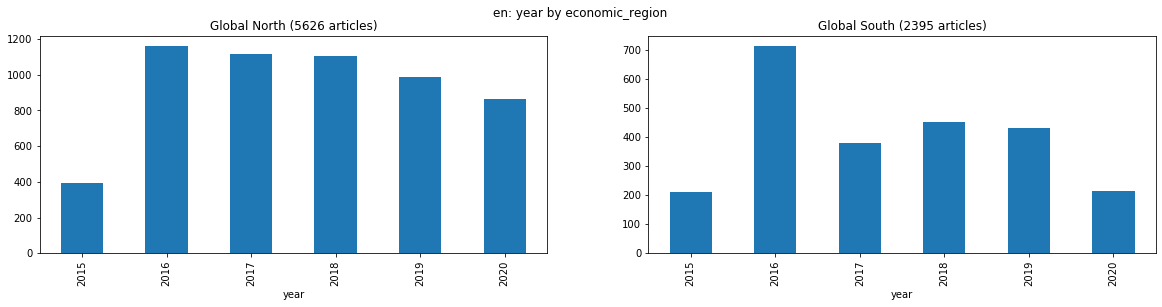

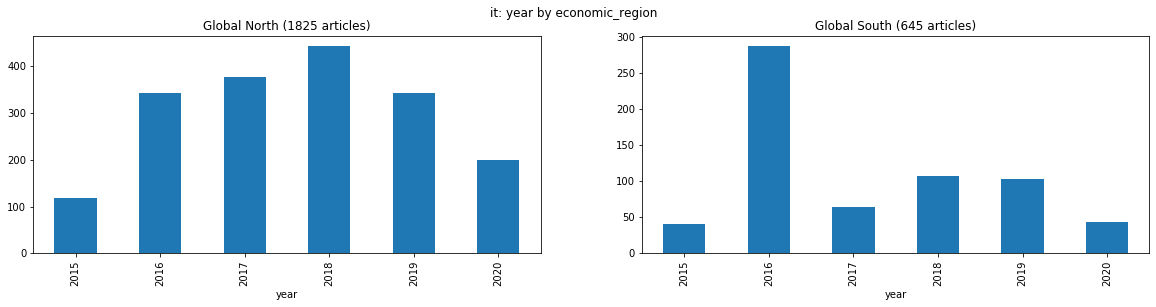

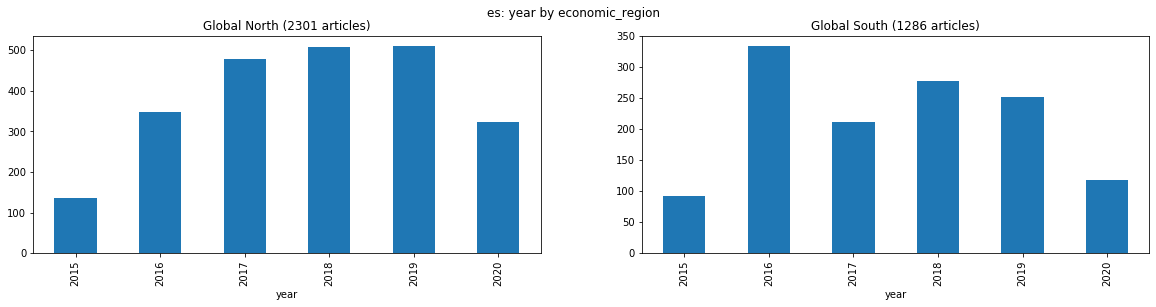

In [19]:
plot_cat_by_cat(df, 'year', 'economic_region', figsize=(20, 4))

# Regression

### Notes for Regression:
- Year as baseline?
- Control vs. investigated variables
- Was it in the "recent news" page? or otherwise advertised?
- if event was in country where the wiki edition is the (a) main language
    + distance from main-language speakers of this Wikipedia version

### Tentitative findings
- single-region wikis have higher r² fit for regression and general significance
- There are more articles about sports, but they receive the same amount of attention AS A WHOLE

### TODO: 
- TODO regression with factor/specific cats
- TODO second model which includes attention before event? should we handle disasters separately either way?

In [20]:
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import summary_table
import numpy as np
import matplotlib.pyplot as plt

In [21]:
countries_version = {'en': ['United States'], 'it': ['Italy'], 'de': ['Germany'], 'es': ['Spain']}
version_language = {'en': 'English', 'it': 'Italian', 'de': 'German', 'es': 'Spanish'}
lang_map = pd.read_csv('languages/langs.csv')

In [22]:
df_crawled = df_crawled[~pd.isna(df_crawled.Year)]
df_crawled['in_code_lang'] = df_crawled.apply(lambda row: version_language[row.code] in (lang_map[lang_map.Country==row.country]['Official language'].values if len(lang_map[lang_map.Country==row.country]) > 0 else ['0'])[0], axis=1)
df_crawled['in_code_region'] = df_crawled.apply(lambda row: row.country in countries_version[row.code], axis=1)

In [460]:
d = {'pagetitle': df_crawled['pagetitle'],
     'views_before_sum': np.log1p(df_crawled['views_before_sum']),
     'views_7_sum': np.log1p(df_crawled['views_7_sum']),
     'diff_days':df_crawled['diff_days'].apply(lambda x:np.log(x+abs(min(df.diff_days))+1)),
     'economic_region':df_crawled['economic_region'],
     'cat': df_crawled['cat'],
     'planed': df_crawled['planed'],
     'surprising': df_crawled['surprising'],
     'factor': df_crawled['factor'], # surprising or planned?
     'year': df_crawled['year'].astype(int),
     'code': df_crawled['code'],
     'bing_news': np.log1p(df_crawled['bing_hits']),
     'bing_attention': df_crawled.bing_hits.apply(lambda views: 'low' if views < 6 else 'high'), # this is probably not a good idea here: maybe get quantiles?
     'gdp_pc': np.log1p(df_crawled['GDP_pc']),
     'gdp_pc_raw': df_crawled['GDP_pc'],
     'gdp': np.log1p(df_crawled['GDP']),
     'gdp_raw': np.log1p(df_crawled['GDP']),
     'oecd': df_crawled['oecd'],
     'in_code_region': df_crawled['in_code_region'], # factor, would also work with wikistats
     'in_code_lang': df_crawled['in_code_lang'],
     'edits_7_sum': np.log1p(df_crawled['edits_7_sum']),
     'gni_class': df_crawled['gni_class'],
     'gni_region': df_crawled['gni_region'],
     'population': np.log1p(df_crawled['population'])
    }

data = pd.DataFrame(data=d)

# add views in year before
wiki_views = pd.read_csv('viewsglobal/views_all.csv')
wiki_views['year_after'] = wiki_views.date.str[:4].astype(int) + 1
wiki_views_mean = np.log1p(wiki_views.groupby(['code', 'year_after']).mean()).rename({'views': 'mean_views_wiki'}, axis=1)
data = data.merge(wiki_views_mean, left_on=['code', 'year'], right_on=['code', 'year_after'], how='left')

data.head()

,pagetitle,views_before_sum,views_7_sum,diff_days,economic_region,cat,planed,surprising,factor,year,...,gdp,gdp_raw,oecd,in_code_region,in_code_lang,edits_7_sum,gni_class,gni_region,population,mean_views_wiki
0,2015 Swedish Open,0.000000,7.906547,8.670086,Global North,sports,planed,not_surprising,before,2015,...,26.948030,26.948030,True,False,False,1.945910,H,Europe & Central Asia,16.097810,19.339906
1,2015 Chama Cha Mapinduzi presidential primaries,0.000000,6.975414,8.671801,Global South,politics,planed,not_surprising,before,2015,...,24.581436,24.581436,False,False,True,3.688879,L,Sub-Saharan Africa,17.756755,19.339906
2,2015 Ji'an bus accident,0.000000,7.057898,8.672144,Global South,disaster,not_planed,surprising,surprising,2015,...,30.034498,30.034498,False,False,False,3.713572,UM,East Asia & Pacific,21.045248,19.339906
3,Aleppo offensive (July 2015),0.000000,7.771910,8.672828,Global South,politics,not_planed,not_surprising,after,2015,...,23.717324,23.717324,False,False,False,2.564949,LM,Middle East & North Africa,16.705739,19.339906
4,2015–16 UEFA Europa League,9.297068,11.333153,8.530702,Global North,sports,planed,not_surprising,before,2015,...,27.809267,27.809267,True,False,False,2.639057,H,Europe & Central Asia,17.653776,19.339906


## Some stats

In [24]:
results = data.groupby(['code', 'cat'])[['views_7_sum', 'bing_news']].sum().rename({'views_7_sum': 'median:views_7_sum', 'edits_7_sum': 'median:edits_7_sum', 'bing_news': 'median:bing_news'}, axis=1)
results = pd.concat([results, data.groupby(['code', 'cat'])[['views_7_sum', 'bing_news']].median().rename({'views_7_sum': 'sum:views_7_sum', 'edits_7_sum': 'sum:edits_7_sum', 'bing_news': 'sum:bing_news'}, axis=1)], axis=1)
results = pd.concat([results, data.groupby(['code', 'cat'])[['views_7_sum', 'bing_news']].mean().rename({'views_7_sum': 'mean:views_7_sum', 'edits_7_sum': 'mean:edits_7_sum', 'bing_news': 'mean:bing_news'}, axis=1)], axis=1)
results = pd.concat([results, data.groupby(['code', 'cat'])[['views_7_sum']].count().rename({'views_7_sum': 'n_articles'}, axis=1)], axis=1)
results

median:views_7_sum  median:bing_news  sum:views_7_sum  \
code cat                                                                
de   culture            838.017402        508.488670         8.729546   
     disaster          1927.999580       1052.331085         9.461008   
     politics          2893.703417       1876.321961         9.000853   
     sports            8184.450247       5344.380550         5.741398   
     undefined           51.872768         44.080827         5.958728   
en   culture           4903.588024       4493.206430         8.328289   
     disaster          7328.768006       4269.848984         9.272375   
     politics         15861.332924      12440.907736         8.805450   
     sports           32369.376635      31272.279625         8.113426   
     undefined         1097.466797       1124.579750         7.864420   
es   culture            796.328717        942.655761         7.652546   
     disaster          1907.488616       1728.536245         7.206986   
     politics          4080.342016       5104.771305         7.545386   
     sports           10713.199981      12490.315529         6.716595   
     undefined         3596.350606       4837.703275         6.423247   
it   culture            718.384260        456.380997         7.125373   
     disaster           372.079770        234.136163         6.719223   
     politics          1116.327675       1095.492100         6.864848   
     sports            6686.798083       5960.232697         5.556828   
     undefined         2303.027643       1987.034363         7.938802   

                sum:bing_news  mean:views_7_sum  mean:bing_news  n_articles  
code cat                                                                     
de   culture         4.297262          8.215857        4.985183         102  
     disaster        3.839394          8.684683        4.740230         222  
     politics        4.317488          8.637921        5.600961         335  
     sports          3.135494          6.247672        4.079680        1310  
     undefined       4.042897          6.484096        5.510103           8  
en   culture         9.409273          8.425409        7.720286         582  
     disaster        3.912023          9.276922        5.404872         790  
     politics        4.110874          8.734214        6.850720        1816  
     sports          9.457279          8.186489        7.909024        3954  
     undefined       9.817347          8.069609        8.268969         136  
es   culture         9.770013          7.305768        8.648218         109  
     disaster        7.155122          7.280491        6.597467         262  
     politics        9.830971          7.641090        9.559497         534  
     sports          8.976009          6.674891        7.782128        1605  
     undefined      10.140572          6.863265        9.232258         524  
it   culture         4.033261          7.183843        4.563810         100  
     disaster        3.367296          6.890366        4.335855          54  
     politics        8.163656          6.848636        6.720810         163  
     sports          4.158883          5.690892        5.072538        1175  
     undefined       7.635787          7.501719        6.472425         307

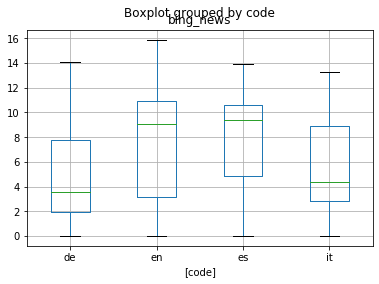

In [25]:
data[['code', 'bing_news']].boxplot(by='code')

In [255]:
def plot_scatter_cat_by_cat(df, col_plt='code', col_cat='cat', val_y='bing_news', val_x='views_7_sum', figsize=(30, 8)):
    df_checknews = df[[col_plt, col_cat, val_x, val_y]].copy()
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=figsize)
    c = ['blue', 'red', 'orange', 'green', 'black', 'brown', 'magenta']

    for i, c1 in enumerate(df_checknews[col_plt].unique()): 
        ax[i].set_title(f'{c1}: Column {col_cat}')
        for j, c2 in enumerate(df_checknews[col_cat].unique()):
            df_points = df_checknews[(df_checknews[col_plt] == c1) & (df_checknews[col_cat] == c2)]
            df_points.plot(y=val_y, x=val_x, kind='scatter', ax=ax[i], c=c[j], alpha=.5, label=f'{c2}({len(df_points)})')
    fig.suptitle(f'Compare "{col_cat}" by "{col_plt}"', fontsize=20)

WATCH OUT FOR AXIS SIZE!!!
this makes it a bit tricky to categorize the data via quantiles. should we go through overall data, or categorized by lang?


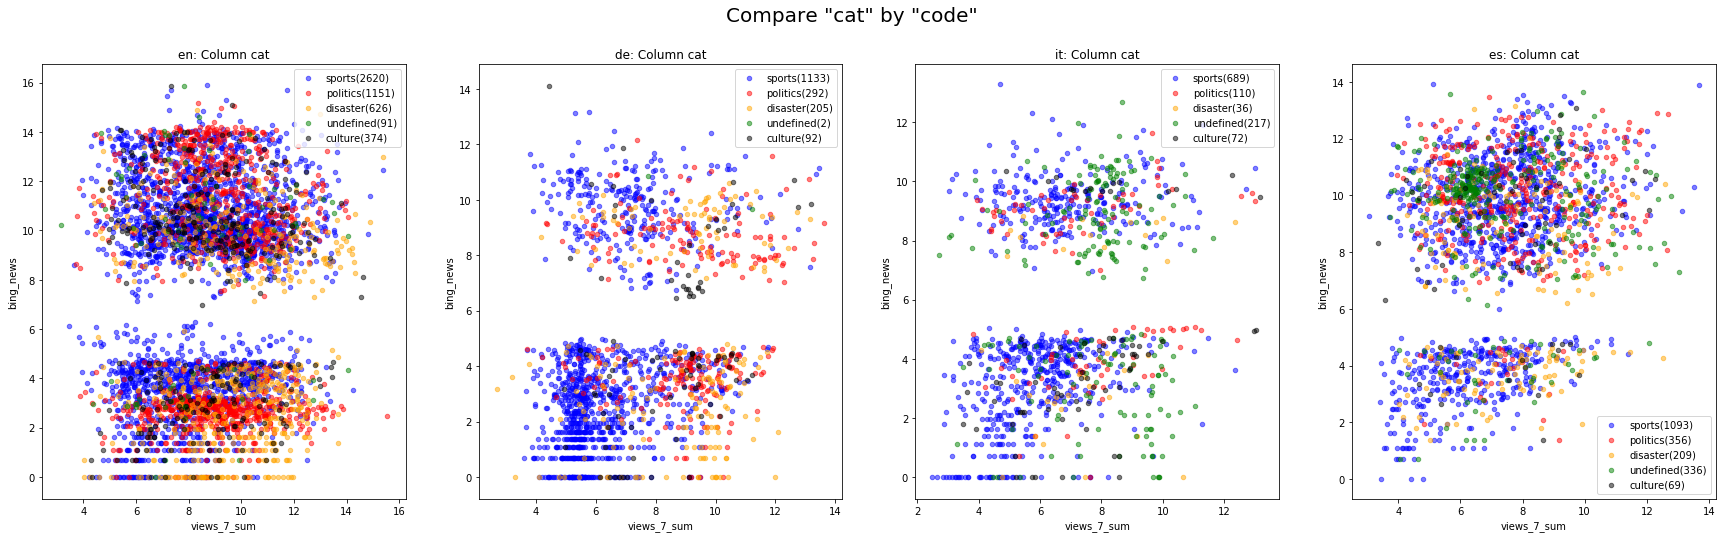

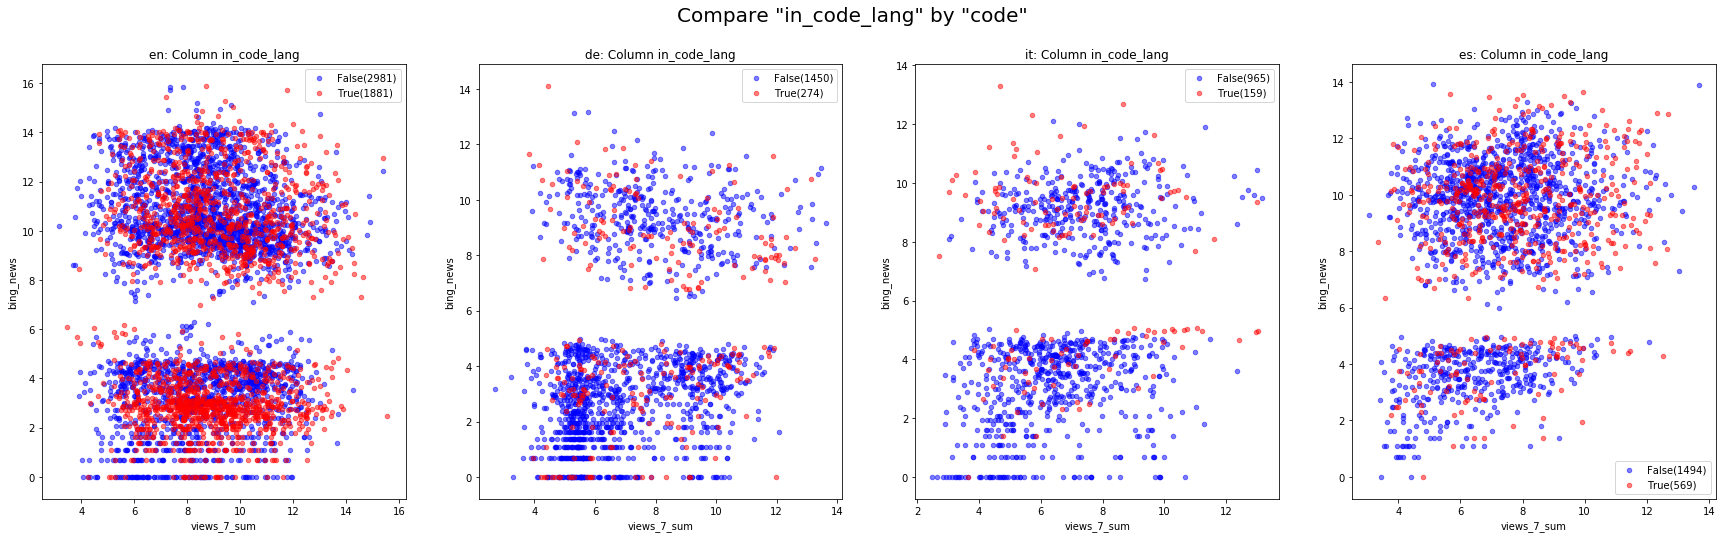

In [63]:
print('WATCH OUT FOR AXIS SIZE!!!')
print('this makes it a bit tricky to categorize the data via quantiles. should we go through overall data, or categorized by lang?')
plot_scatter_cat_by_cat(data[(data.edits_7_sum > np.log1p(1)) & (data.views_7_sum > np.log1p(10))], 'code', 'cat')
#plot_scatter_cat_by_cat(data, 'code', 'in_code_region')
plot_scatter_cat_by_cat(data[(data.edits_7_sum > np.log1p(1)) & (data.views_7_sum > np.log1p(10))], 'code', 'in_code_lang')

WATCH OUT FOR AXIS SIZE!!!
this makes it a bit tricky to categorize the data via quantiles. should we go through overall data, or categorized by lang?


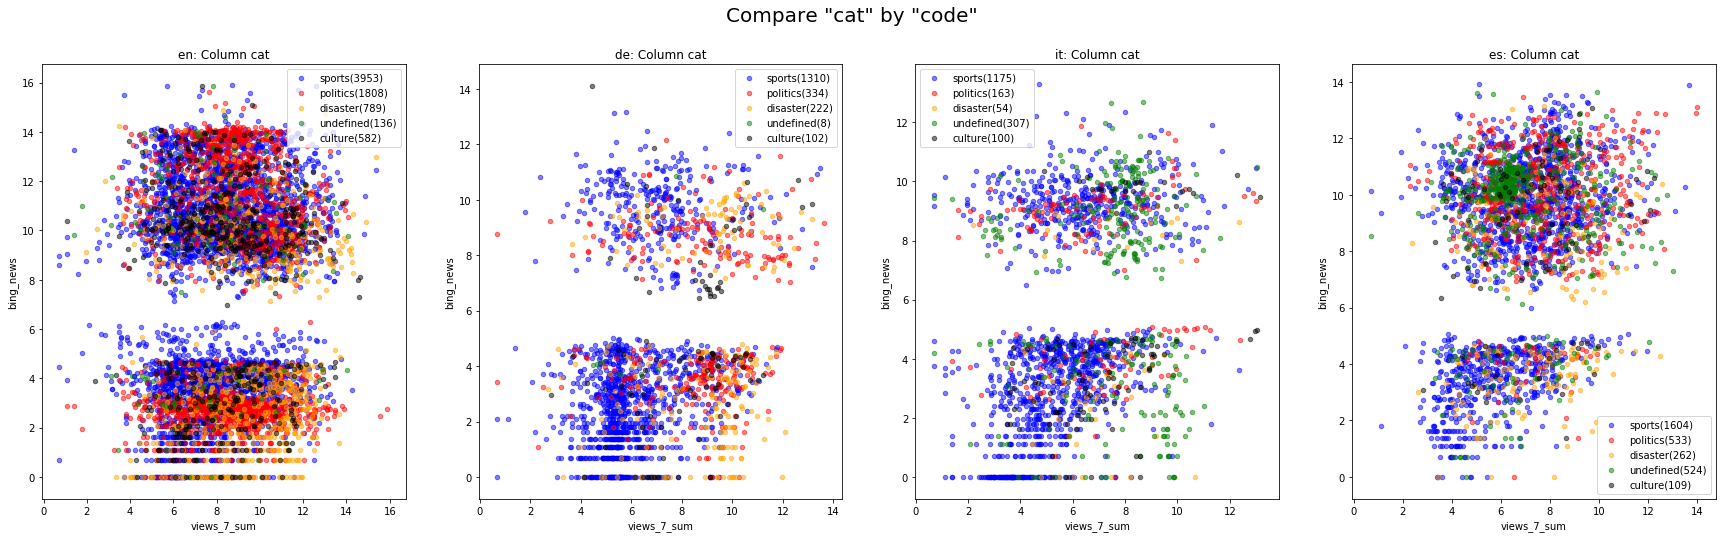

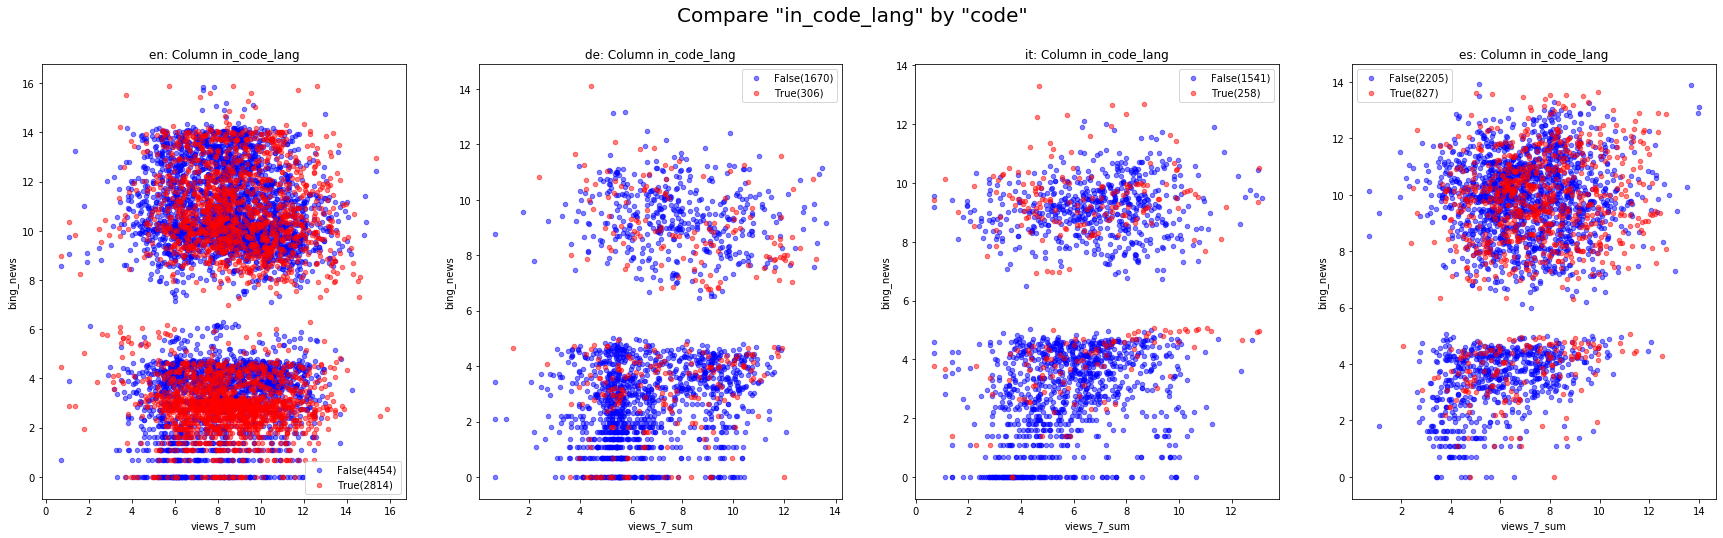

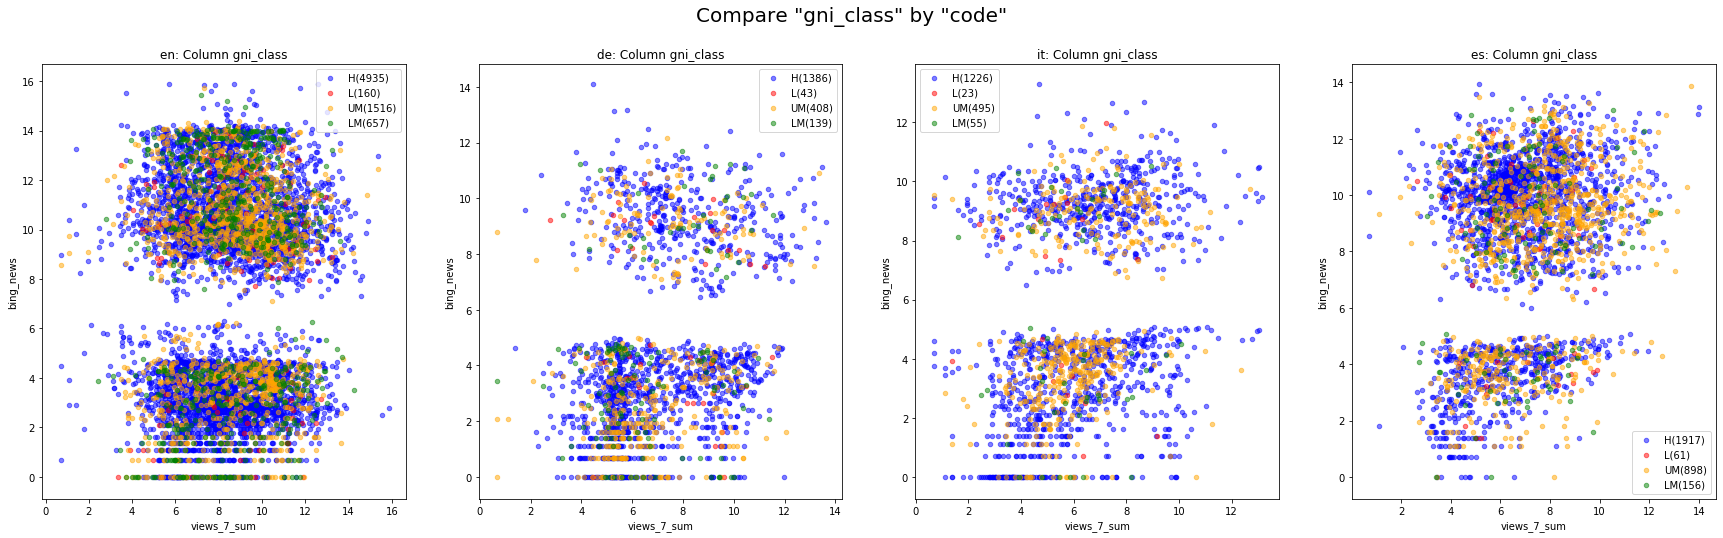

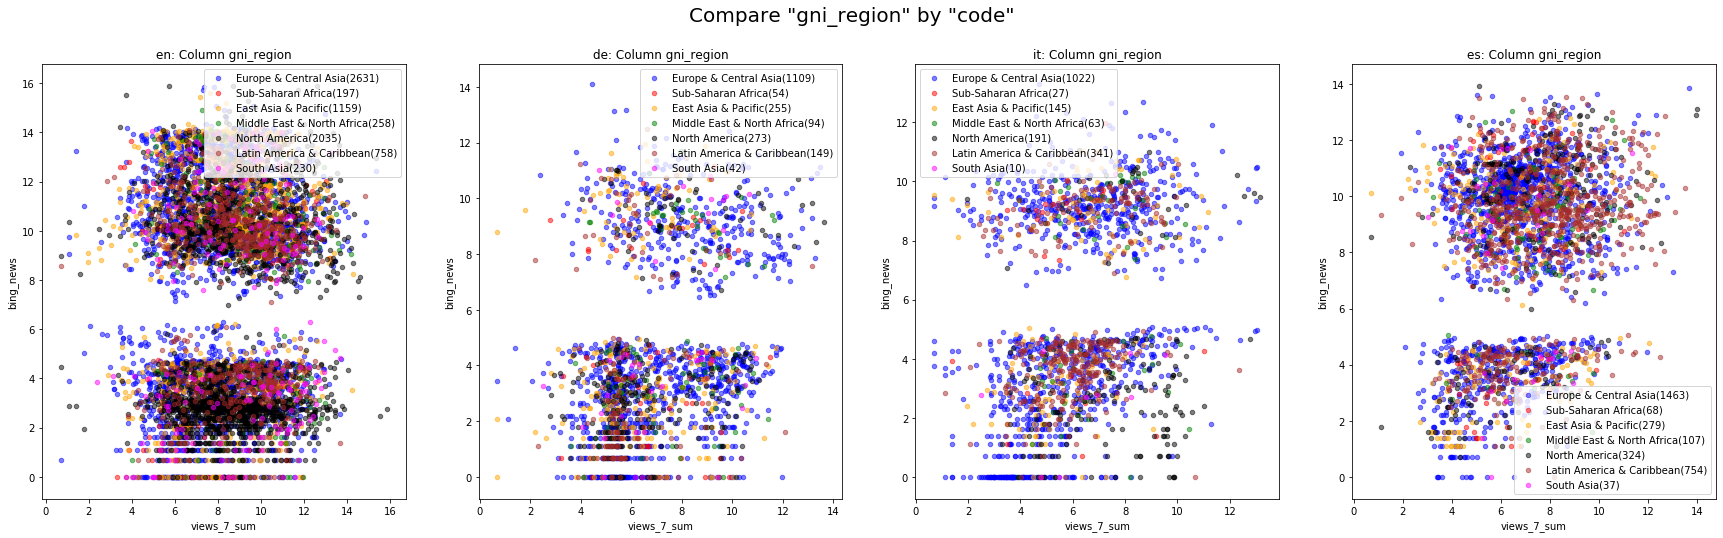

In [257]:
print('WATCH OUT FOR AXIS SIZE!!!')
print('this makes it a bit tricky to categorize the data via quantiles. should we go through overall data, or categorized by lang?')
plot_scatter_cat_by_cat(data, 'code', 'cat')
#plot_scatter_cat_by_cat(data, 'code', 'in_code_region')
plot_scatter_cat_by_cat(data, 'code', 'in_code_lang')
plot_scatter_cat_by_cat(data, 'code', 'gni_class')
plot_scatter_cat_by_cat(data, 'code', 'gni_region')

## Fitting just by code, cat and gdp

- log-coefficient interpretation: https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/

- GDP might just be modeling the country size?
- Could also try and use pageviews in the month before the event (year?) from that country to Wikipedia in general:
https://stats.wikimedia.org/#/de.wikipedia.org/reading/page-views-by-country/normal|map|last-month|(access)~desktop*mobile-app*mobile-web|monthly
    + Could also match this to country data (views from country where event happened to this wikipedia) - this match actually a better predictor!
    + just looking at data for general wikipedia edition views is not that helpful it seems - makes sense, this is already in code
- which articles to consider? by mean_views_wiki/year, just use all with more than 10 views, etc.
    + "hard views" is not a good factor!!! as it would leave as with more english articles than anything else.

In [500]:
# gdp as a baseline for internet access
# in_code_lang*code to assess the effect of the event region speaking the language of the given wikipedia
# cat*code: to catch the language version's affinity with a specific category/topic
model_views0 = smf.ols(formula='views_7_sum ~ (gdp * population * cat)', data=data[(data.views_7_sum > np.log1p(10)) & (data.code == 'en') & (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')
# model = smf.ols(formula='views_7_sum ~ gdp + cat * code', data=data[data.views_7_sum > np.log1p(np.expm1(data.mean_views_wiki) / 10**6)]).fit()
display(model_views0.summary2())
display(sm.stats.anova_lm(model_views0)) # anova shows us whether variability is reduced significantly by a "coefficient group"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
=================================================================================
Model:                    OLS                  Adj. R-squared:         0.058     
Dependent Variable:       views_7_sum          AIC:                    30505.5016
Date:                     2022-02-07 13:14     BIC:                    30615.4187
No. Observations:         7114                 Log-Likelihood:         -15237.   
Df Model:                 15                   F-statistic:            30.12     
Df Residuals:             7098                 Prob (F-statistic):     5.83e-84  
R-squared:                0.060                Scale:                  4.2545    
---------------------------------------------------------------------------------
                                Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
---------------------------------------------------------------------------------
Intercept                       36.0827  12.8003  2.8189 0.0048  10.9904  61.1750
cat[T.disaster]                -34.8418  16.7208 -2.0837 0.0372 -67.6196  -2.0640
cat[T.politics]                -29.1131  13.2493 -2.1973 0.0280 -55.0857  -3.1405
cat[T.sports]                  -37.2662  13.4218 -2.7765 0.0055 -63.5770 -10.9555
gdp                             -0.9649   0.4746 -2.0333 0.0421  -1.8952  -0.0346
gdp:cat[T.disaster]              1.3831   0.6184  2.2365 0.0253   0.1708   2.5954
gdp:cat[T.politics]              1.0067   0.4956  2.0314 0.0422   0.0352   1.9782
gdp:cat[T.sports]                1.1032   0.4985  2.2131 0.0269   0.1260   2.0804
population                      -2.1071   0.6976 -3.0207 0.0025  -3.4745  -0.7397
population:cat[T.disaster]       2.2246   0.9221  2.4125 0.0159   0.4170   4.0323
population:cat[T.politics]       2.3051   0.7240  3.1838 0.0015   0.8858   3.7243
population:cat[T.sports]         2.7764   0.7331  3.7872 0.0002   1.3393   4.2135
gdp:population                   0.0731   0.0253  2.8906 0.0039   0.0235   0.1227
gdp:population:cat[T.disaster]  -0.0842   0.0335 -2.5165 0.0119  -0.1498  -0.0186
gdp:population:cat[T.politics]  -0.0789   0.0264 -2.9914 0.0028  -0.1306  -0.0272
gdp:population:cat[T.sports]    -0.0860   0.0266 -3.2326 0.0012  -0.1382  -0.0338
---------------------------------------------------------------------------------
Omnibus:                    48.736            Durbin-Watson:               1.790 
Prob(Omnibus):              0.000             Jarque-Bera (JB):            34.772
Skew:                       0.047             Prob(JB):                    0.000 
Kurtosis:                   2.671             Condition No.:               665512
=================================================================================
* The condition number is large (7e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
cat,3.0,935.151006,311.717002,73.268094,1.154959e-46
gdp,1.0,245.046521,245.046521,57.597409,3.627405e-14
gdp:cat,3.0,335.651678,111.883893,26.297955,6.552897e-17
population,1.0,127.664388,127.664388,30.007110,4.452219e-08
population:cat,3.0,228.909993,76.303331,17.934856,1.361938e-11
gdp:population,1.0,4.805355,4.805355,1.129484,2.879217e-01
gdp:population:cat,3.0,44.789258,14.929753,3.509191,1.462238e-02
Residual,7098.0,30198.237230,4.254471,NaN,NaN


In [496]:
# gdp as a baseline for internet access
# in_code_lang*code to assess the effect of the event region speaking the language of the given wikipedia
# cat*code: to catch the language version's affinity with a specific category/topic
model_views0 = smf.ols(formula='views_7_sum ~ (gdp_pc + population + cat) * C(code, Treatment("en"))', data=data[(data.views_7_sum > np.log1p(10)) & (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')
# model = smf.ols(formula='views_7_sum ~ gdp + cat * code', data=data[data.views_7_sum > np.log1p(np.expm1(data.mean_views_wiki) / 10**6)]).fit()
display(model_views0.summary2())
display(sm.stats.anova_lm(model_views0)) # anova shows us whether variability is reduced significantly by a "coefficient group"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
==============================================================================================
Model:                       OLS                       Adj. R-squared:              0.225     
Dependent Variable:          views_7_sum               AIC:                         54945.0023
Date:                        2022-02-07 13:14          BIC:                         55124.3841
No. Observations:            13020                     Log-Likelihood:              -27449.   
Df Model:                    23                        F-statistic:                 165.3     
Df Residuals:                12996                     Prob (F-statistic):          0.00      
R-squared:                   0.226                     Scale:                       3.9762    
----------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------------------------------
Intercept                                       6.0793   0.3346 18.1674 0.0000  5.4233  6.7352
cat[T.disaster]                                 0.8674   0.1115  7.7806 0.0000  0.6489  1.0859
cat[T.politics]                                 0.3667   0.0955  3.8404 0.0001  0.1795  0.5539
cat[T.sports]                                  -0.1683   0.0891 -1.8890 0.0589 -0.3429  0.0063
C(code, Treatment("en"))[T.de]                 -1.0443   0.7807 -1.3377 0.1810 -2.5745  0.4859
C(code, Treatment("en"))[T.es]                  1.7339   0.7366  2.3538 0.0186  0.2900  3.1778
C(code, Treatment("en"))[T.it]                 -3.8837   1.1029 -3.5215 0.0004 -6.0455 -1.7219
cat[T.disaster]:C(code, Treatment("en"))[T.de] -0.1029   0.2682 -0.3837 0.7012 -0.6286  0.4228
cat[T.politics]:C(code, Treatment("en"))[T.de]  0.3927   0.2509  1.5651 0.1176 -0.0991  0.8845
cat[T.sports]:C(code, Treatment("en"))[T.de]   -1.6402   0.2246 -7.3028 0.0000 -2.0804 -1.2000
cat[T.disaster]:C(code, Treatment("en"))[T.es] -0.9871   0.2553 -3.8658 0.0001 -1.4876 -0.4866
cat[T.politics]:C(code, Treatment("en"))[T.es] -0.0247   0.2328 -0.1060 0.9156 -0.4809  0.4316
cat[T.sports]:C(code, Treatment("en"))[T.es]   -0.4343   0.2167 -2.0041 0.0451 -0.8591 -0.0095
cat[T.disaster]:C(code, Treatment("en"))[T.it] -0.7999   0.3687 -2.1695 0.0301 -1.5226 -0.0772
cat[T.politics]:C(code, Treatment("en"))[T.it] -0.0019   0.2927 -0.0066 0.9947 -0.5757  0.5718
cat[T.sports]:C(code, Treatment("en"))[T.it]   -0.9329   0.2337 -3.9922 0.0001 -1.3910 -0.4749
gdp_pc                                         -0.0120   0.0206 -0.5835 0.5596 -0.0523  0.0283
gdp_pc:C(code, Treatment("en"))[T.de]           0.2517   0.0462  5.4484 0.0000  0.1612  0.3423
gdp_pc:C(code, Treatment("en"))[T.es]          -0.1223   0.0437 -2.7984 0.0051 -0.2079 -0.0366
gdp_pc:C(code, Treatment("en"))[T.it]           0.0998   0.0638  1.5642 0.1178 -0.0253  0.2249
population                                      0.1344   0.0138  9.7478 0.0000  0.1074  0.1614
population:C(code, Treatment("en"))[T.de]      -0.0993   0.0308 -3.2207 0.0013 -0.1597 -0.0389
population:C(code, Treatment("en"))[T.es]      -0.0876   0.0299 -2.9303 0.0034 -0.1462 -0.0290
population:C(code, Treatment("en"))[T.it]       0.0828   0.0370  2.2374 0.0253  0.0103  0.1553
----------------------------------------------------------------------------------------------
Omnibus:                       59.684                 Durbin-Watson:                    1.805 
Prob(Omnibus):                 0.000                  Jarque-Bera (JB):                 58.131
Skew:                          0.145                  Prob(JB):                         0.000 
Kurtosis:                      2.848                  Condition No.:                    1412  
========================================================================================

,df,sum_sq,mean_sq,F,PR(>F)
cat,3.0,4696.595762,1565.531921,393.725259,8.414349e-245
"C(code, Treatment(""en""))",3.0,8487.734028,2829.244676,711.544159,0.000000e+00
"cat:C(code, Treatment(""en""))",9.0,1197.191120,133.021236,33.454329,7.893461e-59
gdp_pc,1.0,1.172285,1.172285,0.294825,5.871543e-01
"gdp_pc:C(code, Treatment(""en""))",3.0,181.230821,60.410274,15.192952,7.241205e-10
population,1.0,453.009355,453.009355,113.930111,1.737714e-26
"population:C(code, Treatment(""en""))",3.0,102.667109,34.222370,8.606794,1.052415e-05
Residual,12996.0,51674.746174,3.976204,NaN,NaN


In [468]:
# gdp as a baseline for internet access
# in_code_lang*code to assess the effect of the event region speaking the language of the given wikipedia
# cat*code: to catch the language version's affinity with a specific category/topic
model_views0 = smf.ols(formula='views_7_sum ~ ((gdp_pc + population) + cat) * code', data=data[(data.views_7_sum > np.log1p(10)) & (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')
# model = smf.ols(formula='views_7_sum ~ gdp + cat * code', data=data[data.views_7_sum > np.log1p(np.expm1(data.mean_views_wiki) / 10**6)]).fit()
display(model_views0.summary2())
display(sm.stats.anova_lm(model_views0)) # anova shows us whether variability is reduced significantly by a "coefficient group"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                 OLS                Adj. R-squared:       0.225     
Dependent Variable:    views_7_sum        AIC:                  54945.0023
Date:                  2022-02-07 12:59   BIC:                  55124.3841
No. Observations:      13020              Log-Likelihood:       -27449.   
Df Model:              23                 F-statistic:          165.3     
Df Residuals:          12996              Prob (F-statistic):   0.00      
R-squared:             0.226              Scale:                3.9762    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   5.0350   0.7053  7.1388 0.0000  3.6525  6.4175
cat[T.disaster]             0.7645   0.2439  3.1344 0.0017  0.2864  1.2426
cat[T.politics]             0.7594   0.2320  3.2731 0.0011  0.3046  1.2142
cat[T.sports]              -1.8085   0.2062 -8.7714 0.0000 -2.2126 -1.4043
code[T.en]                  1.0443   0.7807  1.3377 0.1810 -0.4859  2.5745
code[T.es]                  2.7782   0.9634  2.8838 0.0039  0.8898  4.6665
code[T.it]                 -2.8394   1.2656 -2.2435 0.0249 -5.3202 -0.3586
cat[T.disaster]:code[T.en]  0.1029   0.2682  0.3837 0.7012 -0.4228  0.6286
cat[T.politics]:code[T.en] -0.3927   0.2509 -1.5651 0.1176 -0.8845  0.0991
cat[T.sports]:code[T.en]    1.6402   0.2246  7.3028 0.0000  1.2000  2.0804
cat[T.disaster]:code[T.es] -0.8842   0.3351 -2.6390 0.0083 -1.5410 -0.2275
cat[T.politics]:code[T.es] -0.4173   0.3145 -1.3271 0.1845 -1.0338  0.1991
cat[T.sports]:code[T.es]    1.2059   0.2856  4.2230 0.0000  0.6462  1.7656
cat[T.disaster]:code[T.it] -0.6970   0.4278 -1.6293 0.1033 -1.5355  0.1415
cat[T.politics]:code[T.it] -0.3946   0.3611 -1.0929 0.2745 -1.1024  0.3132
cat[T.sports]:code[T.it]    0.7073   0.2986  2.3683 0.0179  0.1219  1.2926
gdp_pc                      0.2397   0.0414  5.7950 0.0000  0.1586  0.3208
gdp_pc:code[T.en]          -0.2517   0.0462 -5.4484 0.0000 -0.3423 -0.1612
gdp_pc:code[T.es]          -0.3740   0.0565 -6.6148 0.0000 -0.4848 -0.2631
gdp_pc:code[T.it]          -0.1519   0.0732 -2.0742 0.0381 -0.2954 -0.0083
population                  0.0351   0.0276  1.2732 0.2030 -0.0189  0.0891
population:code[T.en]       0.0993   0.0308  3.2207 0.0013  0.0389  0.1597
population:code[T.es]       0.0117   0.0383  0.3058 0.7598 -0.0633  0.0867
population:code[T.it]       0.1821   0.0440  4.1344 0.0000  0.0958  0.2684
--------------------------------------------------------------------------
Omnibus:                 59.684          Durbin-Watson:             1.805 
Prob(Omnibus):           0.000           Jarque-Bera (JB):          58.131
Skew:                    0.145           Prob(JB):                  0.000 
Kurtosis:                2.848           Condition No.:             2274  
==========================================================================
* The condition number is large (2e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
cat,3.0,4696.595762,1565.531921,393.725259,8.414349e-245
code,3.0,8487.734028,2829.244676,711.544159,0.000000e+00
cat:code,9.0,1197.191120,133.021236,33.454329,7.893461e-59
gdp_pc,1.0,1.172285,1.172285,0.294825,5.871543e-01
gdp_pc:code,3.0,181.230821,60.410274,15.192952,7.241205e-10
population,1.0,453.009355,453.009355,113.930111,1.737714e-26
population:code,3.0,102.667109,34.222370,8.606794,1.052415e-05
Residual,12996.0,51674.746174,3.976204,NaN,NaN


In [67]:
# gdp as a baseline for internet access
# in_code_lang*code to assess the effect of the event region speaking the language of the given wikipedia
# cat*code: to catch the language version's affinity with a specific category/topic
model_views0 = smf.ols(formula='views_7_sum ~ (gdp_pc + in_code_lang + cat) * code', data=data[(data.views_7_sum > np.log1p(10))]).fit() #& (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')
# model = smf.ols(formula='views_7_sum ~ gdp + cat * code', data=data[data.views_7_sum > np.log1p(np.expm1(data.mean_views_wiki) / 10**6)]).fit()
display(model_views0.summary2())
display(sm.stats.anova_lm(model_views0)) # anova shows us whether variability is reduced significantly by a "coefficient group"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS                  Adj. R-squared:         0.213     
Dependent Variable:     views_7_sum          AIC:                    59161.4275
Date:                   2022-01-25 17:58     BIC:                    59372.7383
No. Observations:       14000                Log-Likelihood:         -29553.   
Df Model:               27                   F-statistic:            141.6     
Df Residuals:           13972                Prob (F-statistic):     0.00      
R-squared:              0.215                Scale:                  3.9986    
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        5.8982   0.4954 11.9058 0.0000  4.9271  6.8692
in_code_lang[T.True]             0.2484   0.1328  1.8712 0.0613 -0.0118  0.5087
cat[T.disaster]                  0.7616   0.2446  3.1144 0.0018  0.2823  1.2410
cat[T.politics]                  0.7091   0.2297  3.0866 0.0020  0.2588  1.1594
cat[T.sports]                   -1.7905   0.2071 -8.6457 0.0000 -2.1964 -1.3845
cat[T.undefined]                -1.6360   0.7344 -2.2278 0.0259 -3.0755 -0.1965
code[T.en]                       2.8009   0.5458  5.1315 0.0000  1.7310  3.8708
code[T.es]                       1.7523   0.6556  2.6727 0.0075  0.4672  3.0374
code[T.it]                       0.4475   0.7772  0.5758 0.5648 -1.0759  1.9709
in_code_lang[T.True]:code[T.en]  0.0487   0.1429  0.3406 0.7334 -0.2315  0.3288
in_code_lang[T.True]:code[T.es]  0.2838   0.1584  1.7910 0.0733 -0.0268  0.5943
in_code_lang[T.True]:code[T.it]  0.0847   0.1934  0.4380 0.6614 -0.2944  0.4639
cat[T.disaster]:code[T.en]       0.0919   0.2688  0.3417 0.7326 -0.4351  0.6189
cat[T.politics]:code[T.en]      -0.4065   0.2488 -1.6338 0.1023 -0.8941  0.0812
cat[T.sports]:code[T.en]         1.6323   0.2259  7.2258 0.0000  1.1895  2.0751
cat[T.undefined]:code[T.en]      1.3827   0.7591  1.8215 0.0686 -0.1053  2.8707
cat[T.disaster]:code[T.es]      -0.6629   0.3373 -1.9652 0.0494 -1.3242 -0.0017
cat[T.politics]:code[T.es]      -0.3319   0.3122 -1.0633 0.2877 -0.9439  0.2800
cat[T.sports]:code[T.es]         1.3532   0.2880  4.6994 0.0000  0.7888  1.9177
cat[T.undefined]:code[T.es]      1.2831   0.7641  1.6793 0.0931 -0.2146  2.7808
cat[T.disaster]:code[T.it]      -0.8162   0.4249 -1.9210 0.0547 -1.6490  0.0166
cat[T.politics]:code[T.it]      -0.7575   0.3490 -2.1706 0.0300 -1.4416 -0.0735
cat[T.sports]:code[T.it]         0.4903   0.2958  1.6575 0.0974 -0.0895  1.0702
cat[T.undefined]:code[T.it]      2.1281   0.7702  2.7630 0.0057  0.6184  3.6378
gdp_pc                           0.2113   0.0437  4.8323 0.0000  0.1256  0.2971
gdp_pc:code[T.en]               -0.2527   0.0488 -5.1820 0.0000 -0.3483 -0.1571
gdp_pc:code[T.es]               -0.2728   0.0573 -4.7640 0.0000 -0.3850 -0.1605
gdp_pc:code[T.it]               -0.1399   0.0691 -2.0262 0.0428 -0.2753 -0.0046
-------------------------------------------------------------------------------
Omnibus:                  67.456            Durbin-Watson:               1.804 
Prob(Omnibus):            0.000             Jarque-Bera (JB):            67.208
Skew:                     0.159             Prob(JB):                    0.000 
Kurtosis:                 2.881             Condition No.:               1071  
===============================================================================
* The condition number is large (1e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
in_code_lang,1.0,1923.126280,1923.126280,480.951399,7.715193e-105
cat,4.0,3941.794903,985.448726,246.449205,6.535040e-205
code,3.0,7552.473198,2517.491066,629.595083,0.000000e+00
in_code_lang:code,3.0,85.419379,28.473126,7.120796,8.918183e-05
cat:code,12.0,1654.052660,137.837722,34.471603,8.435057e-80
gdp_pc,1.0,0.002690,0.002690,0.000673,9.793074e-01
gdp_pc:code,3.0,126.252895,42.084298,10.524791,6.542443e-07
Residual,13972.0,55868.265357,3.998588,NaN,NaN


In [70]:
# gdp as a baseline for internet access
# in_code_lang*code to assess the effect of the event region speaking the language of the given wikipedia
# cat*code: to catch the language version's affinity with a specific category/topic
model_views0_nosports = smf.ols(formula='views_7_sum ~ (gdp_pc + in_code_lang + cat) * code', data=data[(data.views_7_sum > np.log1p(10))]).fit() #& (data.cat != 'undefined')
# model = smf.ols(formula='views_7_sum ~ gdp + cat * code', data=data[data.views_7_sum > np.log1p(np.expm1(data.mean_views_wiki) / 10**6)]).fit()
display(model_views0.summary2())
display(sm.stats.anova_lm(model_views0)) # anova shows us whether variability is reduced significantly by a "coefficient group"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS                  Adj. R-squared:         0.213     
Dependent Variable:     views_7_sum          AIC:                    59161.4275
Date:                   2022-01-25 18:00     BIC:                    59372.7383
No. Observations:       14000                Log-Likelihood:         -29553.   
Df Model:               27                   F-statistic:            141.6     
Df Residuals:           13972                Prob (F-statistic):     0.00      
R-squared:              0.215                Scale:                  3.9986    
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        5.8982   0.4954 11.9058 0.0000  4.9271  6.8692
in_code_lang[T.True]             0.2484   0.1328  1.8712 0.0613 -0.0118  0.5087
cat[T.disaster]                  0.7616   0.2446  3.1144 0.0018  0.2823  1.2410
cat[T.politics]                  0.7091   0.2297  3.0866 0.0020  0.2588  1.1594
cat[T.sports]                   -1.7905   0.2071 -8.6457 0.0000 -2.1964 -1.3845
cat[T.undefined]                -1.6360   0.7344 -2.2278 0.0259 -3.0755 -0.1965
code[T.en]                       2.8009   0.5458  5.1315 0.0000  1.7310  3.8708
code[T.es]                       1.7523   0.6556  2.6727 0.0075  0.4672  3.0374
code[T.it]                       0.4475   0.7772  0.5758 0.5648 -1.0759  1.9709
in_code_lang[T.True]:code[T.en]  0.0487   0.1429  0.3406 0.7334 -0.2315  0.3288
in_code_lang[T.True]:code[T.es]  0.2838   0.1584  1.7910 0.0733 -0.0268  0.5943
in_code_lang[T.True]:code[T.it]  0.0847   0.1934  0.4380 0.6614 -0.2944  0.4639
cat[T.disaster]:code[T.en]       0.0919   0.2688  0.3417 0.7326 -0.4351  0.6189
cat[T.politics]:code[T.en]      -0.4065   0.2488 -1.6338 0.1023 -0.8941  0.0812
cat[T.sports]:code[T.en]         1.6323   0.2259  7.2258 0.0000  1.1895  2.0751
cat[T.undefined]:code[T.en]      1.3827   0.7591  1.8215 0.0686 -0.1053  2.8707
cat[T.disaster]:code[T.es]      -0.6629   0.3373 -1.9652 0.0494 -1.3242 -0.0017
cat[T.politics]:code[T.es]      -0.3319   0.3122 -1.0633 0.2877 -0.9439  0.2800
cat[T.sports]:code[T.es]         1.3532   0.2880  4.6994 0.0000  0.7888  1.9177
cat[T.undefined]:code[T.es]      1.2831   0.7641  1.6793 0.0931 -0.2146  2.7808
cat[T.disaster]:code[T.it]      -0.8162   0.4249 -1.9210 0.0547 -1.6490  0.0166
cat[T.politics]:code[T.it]      -0.7575   0.3490 -2.1706 0.0300 -1.4416 -0.0735
cat[T.sports]:code[T.it]         0.4903   0.2958  1.6575 0.0974 -0.0895  1.0702
cat[T.undefined]:code[T.it]      2.1281   0.7702  2.7630 0.0057  0.6184  3.6378
gdp_pc                           0.2113   0.0437  4.8323 0.0000  0.1256  0.2971
gdp_pc:code[T.en]               -0.2527   0.0488 -5.1820 0.0000 -0.3483 -0.1571
gdp_pc:code[T.es]               -0.2728   0.0573 -4.7640 0.0000 -0.3850 -0.1605
gdp_pc:code[T.it]               -0.1399   0.0691 -2.0262 0.0428 -0.2753 -0.0046
-------------------------------------------------------------------------------
Omnibus:                  67.456            Durbin-Watson:               1.804 
Prob(Omnibus):            0.000             Jarque-Bera (JB):            67.208
Skew:                     0.159             Prob(JB):                    0.000 
Kurtosis:                 2.881             Condition No.:               1071  
===============================================================================
* The condition number is large (1e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
in_code_lang,1.0,1923.126280,1923.126280,480.951399,7.715193e-105
cat,4.0,3941.794903,985.448726,246.449205,6.535040e-205
code,3.0,7552.473198,2517.491066,629.595083,0.000000e+00
in_code_lang:code,3.0,85.419379,28.473126,7.120796,8.918183e-05
cat:code,12.0,1654.052660,137.837722,34.471603,8.435057e-80
gdp_pc,1.0,0.002690,0.002690,0.000673,9.793074e-01
gdp_pc:code,3.0,126.252895,42.084298,10.524791,6.542443e-07
Residual,13972.0,55868.265357,3.998588,NaN,NaN


In [73]:
model_views1 = smf.ols(formula='views_7_sum ~ (gdp_pc + bing_news + in_code_lang + cat) * code + gdp_pc * cat', data=data[(data.views_7_sum > np.log1p(10))]).fit() #
display(model_views1.summary2())
display(sm.stats.anova_lm(model_views1))

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS                  Adj. R-squared:         0.246     
Dependent Variable:     views_7_sum          AIC:                    58578.9708
Date:                   2022-01-25 18:03     BIC:                    58850.6560
No. Observations:       14000                Log-Likelihood:         -29253.   
Df Model:               35                   F-statistic:            131.3     
Df Residuals:           13964                Prob (F-statistic):     0.00      
R-squared:              0.248                Scale:                  3.8335    
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        1.8546   0.8807  2.1059 0.0352  0.1283  3.5809
in_code_lang[T.True]             0.1026   0.1309  0.7843 0.4329 -0.1539  0.3592
cat[T.disaster]                  2.5282   0.8279  3.0538 0.0023  0.9054  4.1509
cat[T.politics]                  2.8647   0.8136  3.5209 0.0004  1.2699  4.4595
cat[T.sports]                    3.3050   0.7926  4.1701 0.0000  1.7515  4.8585
cat[T.undefined]                -0.6928   1.2236 -0.5662 0.5713 -3.0911  1.7056
code[T.en]                       3.4182   0.5479  6.2384 0.0000  2.3442  4.4922
code[T.es]                       1.7689   0.6593  2.6828 0.0073  0.4765  3.0612
code[T.it]                      -0.1738   0.7868 -0.2209 0.8252 -1.7161  1.3685
in_code_lang[T.True]:code[T.en]  0.2803   0.1409  1.9895 0.0467  0.0041  0.5565
in_code_lang[T.True]:code[T.es]  0.3567   0.1561  2.2857 0.0223  0.0508  0.6626
in_code_lang[T.True]:code[T.it] -0.1023   0.1932 -0.5297 0.5964 -0.4810  0.2764
cat[T.disaster]:code[T.en]       0.1081   0.2653  0.4073 0.6838 -0.4120  0.6282
cat[T.politics]:code[T.en]      -0.4254   0.2452 -1.7346 0.0828 -0.9060  0.0553
cat[T.sports]:code[T.en]         1.4323   0.2226  6.4336 0.0000  0.9959  1.8687
cat[T.undefined]:code[T.en]      1.4660   0.7448  1.9682 0.0491  0.0060  2.9260
cat[T.disaster]:code[T.es]      -0.5641   0.3336 -1.6911 0.0908 -1.2180  0.0898
cat[T.politics]:code[T.es]      -0.5851   0.3087 -1.8955 0.0580 -1.1901  0.0199
cat[T.sports]:code[T.es]         1.1612   0.2850  4.0748 0.0000  0.6026  1.7198
cat[T.undefined]:code[T.es]      1.0973   0.7492  1.4645 0.1431 -0.3714  2.5659
cat[T.disaster]:code[T.it]      -0.7239   0.4166 -1.7378 0.0823 -1.5405  0.0926
cat[T.politics]:code[T.it]      -0.9269   0.3433 -2.6997 0.0069 -1.5998 -0.2539
cat[T.sports]:code[T.it]         0.3081   0.2900  1.0624 0.2881 -0.2604  0.8767
cat[T.undefined]:code[T.it]      1.8829   0.7548  2.4945 0.0126  0.4034  3.3625
gdp_pc                           0.5320   0.0812  6.5549 0.0000  0.3729  0.6911
gdp_pc:code[T.en]               -0.2833   0.0481 -5.8904 0.0000 -0.3775 -0.1890
gdp_pc:code[T.es]               -0.3282   0.0567 -5.7869 0.0000 -0.4394 -0.2170
gdp_pc:code[T.it]               -0.0847   0.0693 -1.2219 0.2218 -0.2205  0.0512
gdp_pc:cat[T.disaster]          -0.1444   0.0759 -1.9024 0.0571 -0.2932  0.0044
gdp_pc:cat[T.politics]          -0.2012   0.0743 -2.7067 0.0068 -0.3470 -0.0555
gdp_pc:cat[T.sports]            -0.4773   0.0723 -6.6001 0.0000 -0.6190 -0.3355
gdp_pc:cat[T.undefined]         -0.0868   0.0949 -0.9149 0.3603 -0.2728  0.0992
bing_news                        0.1355   0.0136  9.9573 0.0000  0.1088  0.1622
bing_news:code[T.en]            -0.0852   0.0147 -5.7867 0.0000 -0.1140 -0.0563
bing_news:code[T.es]             0.0260   0.0180  1.4412 0.1495 -0.0093  0.0613
bing_news:code[T.it]             0.0247   0.0200  1.2376 0.2159 -0.0144  0.0639
-------------------------------------------------------------------------------
Omnibus:                  39.494            Durbin-Wats

,df,sum_sq,mean_sq,F,PR(>F)
in_code_lang,1.0,1923.126280,1923.126280,501.668928,3.417236e-109
cat,4.0,3941.794903,985.448726,257.065285,1.719754e-213
code,3.0,7552.473198,2517.491066,656.715608,0.000000e+00
in_code_lang:code,3.0,85.419379,28.473126,7.427532,5.743421e-05
cat:code,12.0,1654.052660,137.837722,35.956506,1.817919e-83
gdp_pc,1.0,0.002690,0.002690,0.000702,9.788665e-01
gdp_pc:code,3.0,126.252895,42.084298,10.978158,3.386087e-07
gdp_pc:cat,4.0,484.121095,121.030274,31.572096,3.187112e-26
bing_news,1.0,1394.701088,1394.701088,363.823326,4.308350e-80
bing_news:code,3.0,459.049164,153.016388,39.916031,1.123876e-25


# GNI/REgion from world bank

In [508]:
# GNI_class instead of GDP
# in_code_lang*code to assess the effect of the event region speaking the language of the given wikipedia
# cat*code: to catch the language version's affinity with a specific category/topic
model_views0 = smf.ols(formula='views_7_sum ~ (gni_class * population *  cat) * code', data=data[(data.views_7_sum > np.log1p(10)) & (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')
# model = smf.ols(formula='views_7_sum ~ gdp + cat * code', data=data[data.views_7_sum > np.log1p(np.expm1(data.mean_views_wiki) / 10**6)]).fit()
display(model_views0.summary2())
display(sm.stats.anova_lm(model_views0)) # anova shows us whether variability is reduced significantly by a "coefficient group"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Ordinary least squares
=========================================================================================================
Model:                            OLS                          Adj. R-squared:                 0.250     
Dependent Variable:               views_7_sum                  AIC:                            54609.7689
Date:                             2022-02-07 13:16             BIC:                            55506.6780
No. Observations:                 13020                        Log-Likelihood:                 -27185.   
Df Model:                         119                          F-statistic:                    37.51     
Df Residuals:                     12900                        Prob (F-statistic):             0.00      
R-squared:                        0.257                        Scale:                          3.8468    
---------------------------------------------------------------------------------------------------------
                                                       Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
---------------------------------------------------------------------------------------------------------
Intercept                                               0.9452   2.4735  0.3821 0.7024   -3.9033   5.7938
gni_class[T.L]                                         -2.1640  17.7178 -0.1221 0.9028  -36.8935  32.5655
gni_class[T.LM]                                        -9.8268   8.0556 -1.2199 0.2225  -25.6169   5.9633
gni_class[T.UM]                                         5.5337  28.5291  0.1940 0.8462  -50.3876  61.4551
cat[T.disaster]                                         7.3781   3.5798  2.0611 0.0393    0.3613  14.3950
cat[T.politics]                                         5.4414   2.7717  1.9632 0.0496    0.0084  10.8744
cat[T.sports]                                           7.1052   2.5866  2.7469 0.0060    2.0351  12.1753
code[T.en]                                              0.1216   2.7599  0.0440 0.9649   -5.2882   5.5314
code[T.es]                                             -2.9721   4.7016 -0.6321 0.5273  -12.1879   6.2437
code[T.it]                                             18.2693   5.0550  3.6141 0.0003    8.3607  28.1779
gni_class[T.L]:cat[T.disaster]                          1.6084  20.0580  0.0802 0.9361  -37.7082  40.9249
gni_class[T.LM]:cat[T.disaster]                         4.2628   8.7322  0.4882 0.6254  -12.8535  21.3792
gni_class[T.UM]:cat[T.disaster]                        -6.7935  28.9650 -0.2345 0.8146  -63.5691  49.9822
gni_class[T.L]:cat[T.politics]                          0.1025  20.2922  0.0051 0.9960  -39.6732  39.8782
gni_class[T.LM]:cat[T.politics]                         8.9965   8.3783  1.0738 0.2829   -7.4263  25.4193
gni_class[T.UM]:cat[T.politics]                       -10.2746  28.6236 -0.3590 0.7196  -66.3811  45.8318
gni_class[T.L]:cat[T.sports]                           27.2936  21.9734  1.2421 0.2142  -15.7774  70.3647
gni_class[T.LM]:cat[T.sports]                           6.1341   8.2941  0.7396 0.4596  -10.1236  22.3918
gni_class[T.UM]:cat[T.sports]                          -6.2742  28.5671 -0.2196 0.8262  -62.2699  49.7215
gni_class[T.L]:code[T.en]                              -8.1520  17.7178 -0.4601 0.6455  -42.8814  26.5775
gni_class[T.LM]:code[T.en]                             11.0939   8.3644  1.3263 0.1848   -5.3015  27.4893
gni_class[T.UM]:code[T.en]                              5.0004  28.6971  0.1742 0.8617  -51.2503  61.2510
gni_class[T.L]:code[T.es]                              19.6323  15.9644  1.2298 0.2188  -11.6602  50.9248
gni_class[T.LM]:code[T.es]                            -13.4852  15.6697 -0.8606 0.3895  -44.2001  17.2296
gni_class[T.UM]:code[T.es]                              8.4671  29.4152  0.2878 0.7735  -49.1911  66.1252
gni_class[T.L]:code[T.it]                              -7.4886  27

,df,sum_sq,mean_sq,F,PR(>F)
gni_class,3.0,186.511386,62.170462,16.161506,1.754296e-10
cat,3.0,4650.684813,1550.228271,402.989176,3.044048e-250
code,3.0,8666.019447,2888.673149,750.924256,0.000000e+00
gni_class:cat,9.0,361.939935,40.215548,10.454222,2.841903e-16
gni_class:code,9.0,224.025962,24.891774,6.470734,3.080612e-09
cat:code,9.0,1184.275161,131.586129,34.206437,3.157198e-60
gni_class:cat:code,27.0,536.015566,19.852428,5.160733,5.515043e-17
population,1.0,280.665337,280.665337,72.960282,1.470157e-17
gni_class:population,3.0,117.926467,39.308822,10.218514,1.021795e-06
population:cat,3.0,72.388290,24.129430,6.272559,3.000332e-04


In [361]:
# GNI_class instead of GDP
# in_code_lang*code to assess the effect of the event region speaking the language of the given wikipedia
# cat*code: to catch the language version's affinity with a specific category/topic
model_views0 = smf.ols(formula='views_7_sum ~ (gni_class + cat + in_code_lang) * code', data=data[(data.cat != 'sports')]).fit() #& (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')
# model = smf.ols(formula='views_7_sum ~ gdp + cat * code', data=data[data.views_7_sum > np.log1p(np.expm1(data.mean_views_wiki) / 10**6)]).fit()
display(model_views0.summary2())
display(sm.stats.anova_lm(model_views0)) # anova shows us whether variability is reduced significantly by a "coefficient group"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS                  Adj. R-squared:         0.143     
Dependent Variable:     views_7_sum          AIC:                    26042.9038
Date:                   2022-02-01 14:10     BIC:                    26257.4638
No. Observations:       6033                 Log-Likelihood:         -12989.   
Df Model:               31                   F-statistic:            33.45     
Df Residuals:           6001                 Prob (F-statistic):     1.45e-181 
R-squared:              0.147                Scale:                  4.3648    
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        7.9874   0.2172 36.7711 0.0000  7.5615  8.4132
gni_class[T.L]                  -0.9726   0.3581 -2.7157 0.0066 -1.6747 -0.2705
gni_class[T.LM]                 -1.0000   0.2763 -3.6193 0.0003 -1.5416 -0.4583
gni_class[T.UM]                 -0.4325   0.2281 -1.8958 0.0580 -0.8797  0.0147
cat[T.disaster]                  0.9158   0.2619  3.4963 0.0005  0.4023  1.4292
cat[T.politics]                  0.7269   0.2433  2.9883 0.0028  0.2501  1.2038
cat[T.undefined]                -1.6196   0.7684 -2.1077 0.0351 -3.1260 -0.1132
in_code_lang[T.True]             0.8978   0.2189  4.1009 0.0000  0.4686  1.3270
code[T.en]                       0.2532   0.2399  1.0556 0.2912 -0.2171  0.7235
code[T.es]                      -1.0027   0.3022 -3.3182 0.0009 -1.5950 -0.4103
code[T.it]                      -0.9661   0.3074 -3.1430 0.0017 -1.5687 -0.3635
gni_class[T.L]:code[T.en]        1.0395   0.4024  2.5836 0.0098  0.2508  1.8283
gni_class[T.LM]:code[T.en]       0.8239   0.2977  2.7676 0.0057  0.2403  1.4075
gni_class[T.UM]:code[T.en]       0.2505   0.2547  0.9835 0.3254 -0.2488  0.7497
gni_class[T.L]:code[T.es]        0.7610   0.4616  1.6485 0.0993 -0.1439  1.6659
gni_class[T.LM]:code[T.es]       1.1443   0.3539  3.2330 0.0012  0.4505  1.8382
gni_class[T.UM]:code[T.es]       0.9891   0.2671  3.7031 0.0002  0.4655  1.5127
gni_class[T.L]:code[T.it]       -1.1669   0.5969 -1.9551 0.0506 -2.3370  0.0031
gni_class[T.LM]:code[T.it]      -0.7405   0.4790 -1.5460 0.1222 -1.6795  0.1985
gni_class[T.UM]:code[T.it]      -0.6004   0.3233 -1.8570 0.0634 -1.2341  0.0334
cat[T.disaster]:code[T.en]       0.0509   0.2875  0.1772 0.8594 -0.5126  0.6144
cat[T.politics]:code[T.en]      -0.3892   0.2630 -1.4800 0.1389 -0.9047  0.1263
cat[T.undefined]:code[T.en]      1.3684   0.7941  1.7232 0.0849 -0.1883  2.9252
cat[T.disaster]:code[T.es]      -0.8821   0.3588 -2.4586 0.0140 -1.5854 -0.1788
cat[T.politics]:code[T.es]      -0.3936   0.3288 -1.1970 0.2313 -1.0383  0.2510
cat[T.undefined]:code[T.es]      1.2731   0.7995  1.5924 0.1113 -0.2942  2.8404
cat[T.disaster]:code[T.it]      -0.2934   0.4549 -0.6451 0.5189 -1.1851  0.5983
cat[T.politics]:code[T.it]      -0.4681   0.3691 -1.2681 0.2048 -1.1918  0.2555
cat[T.undefined]:code[T.it]      2.2707   0.8064  2.8157 0.0049  0.6898  3.8515
in_code_lang[T.True]:code[T.en] -0.5293   0.2332 -2.2697 0.0233 -0.9865 -0.0721
in_code_lang[T.True]:code[T.es] -0.5515   0.2518 -2.1904 0.0285 -1.0451 -0.0579
in_code_lang[T.True]:code[T.it]  0.0195   0.3329  0.0585 0.9534 -0.6332  0.6721
-------------------------------------------------------------------------------
Omnibus:                  16.023            Durbin-Watson:               1.817 
Prob(Omnibus):            0.000             Jarque-Bera (JB):            16.061
Skew:                     -0.125            Prob(JB):                    0.000 
Kurtosis:                 3.035             Condition No.:               89    
=======================================================

,df,sum_sq,mean_sq,F,PR(>F)
gni_class,3.0,48.893813,16.297938,3.733939,1.073017e-02
cat,3.0,1458.756557,486.252186,111.402817,3.387749e-70
in_code_lang,1.0,550.758626,550.758626,126.181567,5.453551e-29
code,3.0,1717.398320,572.466107,131.154859,2.699530e-82
gni_class:code,9.0,472.380653,52.486739,12.024975,5.152411e-19
cat:code,9.0,237.042732,26.338081,6.034187,1.810992e-08
in_code_lang:code,3.0,40.829594,13.609865,3.118088,2.500732e-02
Residual,6001.0,26193.227758,4.364810,NaN,NaN


In [355]:
# GNI_class instead of GDP
# in_code_lang*code to assess the effect of the event region speaking the language of the given wikipedia
# cat*code: to catch the language version's affinity with a specific category/topic
model_views0 = smf.ols(formula='views_7_sum ~ (gni_class + cat) * code', data=data[data.views_7_sum > np.log1p(10)]).fit() #& (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')
# model = smf.ols(formula='views_7_sum ~ gdp + cat * code', data=data[data.views_7_sum > np.log1p(np.expm1(data.mean_views_wiki) / 10**6)]).fit()
display(model_views0.summary2())
display(sm.stats.anova_lm(model_views0)) # anova shows us whether variability is reduced significantly by a "coefficient group"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Ordinary least squares
===========================================================================
Model:                  OLS                Adj. R-squared:       0.214     
Dependent Variable:     views_7_sum        AIC:                  59104.5217
Date:                   2022-02-01 14:08   BIC:                  59345.9900
No. Observations:       13987              Log-Likelihood:       -29520.   
Df Model:               31                 F-statistic:          123.7     
Df Residuals:           13955              Prob (F-statistic):   0.00      
R-squared:              0.215              Scale:                3.9969    
---------------------------------------------------------------------------
                             Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                    8.2321   0.1980 41.5728 0.0000  7.8440  8.6203
gni_class[T.L]              -0.9972   0.3193 -3.1233 0.0018 -1.6231 -0.3714
gni_class[T.LM]             -0.8160   0.1817 -4.4905 0.0000 -1.1722 -0.4598
gni_class[T.UM]             -0.2109   0.1141 -1.8482 0.0646 -0.4346  0.0128
cat[T.disaster]              0.7312   0.2447  2.9880 0.0028  0.2515  1.2109
cat[T.politics]              0.6627   0.2291  2.8922 0.0038  0.2136  1.1118
cat[T.sports]               -1.8649   0.2068 -9.0192 0.0000 -2.2702 -1.4596
cat[T.undefined]            -1.6953   0.7344 -2.3084 0.0210 -3.1349 -0.2558
code[T.en]                   0.1848   0.2150  0.8595 0.3901 -0.2366  0.6062
code[T.es]                  -1.0656   0.2764 -3.8558 0.0001 -1.6073 -0.5239
code[T.it]                  -1.0435   0.2814 -3.7078 0.0002 -1.5951 -0.4918
gni_class[T.L]:code[T.en]    0.9783   0.3596  2.7203 0.0065  0.2734  1.6831
gni_class[T.LM]:code[T.en]   0.8528   0.2005  4.2536 0.0000  0.4598  1.2457
gni_class[T.UM]:code[T.en]   0.5414   0.1287  4.2076 0.0000  0.2892  0.7936
gni_class[T.L]:code[T.es]    0.6561   0.4165  1.5752 0.1152 -0.1603  1.4725
gni_class[T.LM]:code[T.es]   0.7502   0.2486  3.0180 0.0025  0.2630  1.2374
gni_class[T.UM]:code[T.es]   0.7827   0.1405  5.5706 0.0000  0.5073  1.0581
gni_class[T.L]:code[T.it]   -0.4714   0.5498 -0.8574 0.3912 -1.5491  0.6063
gni_class[T.LM]:code[T.it]   0.0110   0.3402  0.0323 0.9742 -0.6559  0.6779
gni_class[T.UM]:code[T.it]   0.3192   0.1582  2.0172 0.0437  0.0090  0.6294
cat[T.disaster]:code[T.en]   0.0598   0.2691  0.2224 0.8240 -0.4675  0.5872
cat[T.politics]:code[T.en]  -0.3783   0.2483 -1.5237 0.1276 -0.8649  0.1083
cat[T.sports]:code[T.en]     1.5698   0.2253  6.9673 0.0000  1.1282  2.0114
cat[T.undefined]:code[T.en]  1.3568   0.7591  1.7873 0.0739 -0.1312  2.8448
cat[T.disaster]:code[T.es]  -0.7444   0.3366 -2.2116 0.0270 -1.4041 -0.0846
cat[T.politics]:code[T.es]  -0.3266   0.3114 -1.0488 0.2943 -0.9371  0.2838
cat[T.sports]:code[T.es]     1.2147   0.2863  4.2428 0.0000  0.6535  1.7759
cat[T.undefined]:code[T.es]  1.3129   0.7640  1.7184 0.0857 -0.1847  2.8105
cat[T.disaster]:code[T.it]  -0.6977   0.4260 -1.6377 0.1015 -1.5329  0.1374
cat[T.politics]:code[T.it]  -0.6732   0.3469 -1.9404 0.0523 -1.3532  0.0068
cat[T.sports]:code[T.it]     0.4668   0.2954  1.5798 0.1142 -0.1124  1.0459
cat[T.undefined]:code[T.it]  2.1339   0.7700  2.7712 0.0056  0.6245  3.6433
---------------------------------------------------------------------------
Omnibus:                  63.034          Durbin-Watson:             1.812 
Prob(Omnibus):            0.000           Jarque-Bera (JB):          63.466
Skew:                     0.160           Prob(JB):                  0.000 
Kurtosis:                 2.916           Condition No.:             127   
===========================================================================

"""

,df,sum_sq,mean_sq,F,PR(>F)
gni_class,3.0,195.887079,65.295693,16.336681,1.352686e-10
cat,4.0,4803.885414,1200.971354,300.477496,2.428009e-248
code,3.0,8491.703343,2830.567781,708.195009,0.000000e+00
gni_class:code,9.0,239.667244,26.629694,6.662627,1.432816e-09
cat:code,12.0,1590.430554,132.535880,33.159866,1.471044e-76
Residual,13955.0,55776.407454,3.996876,NaN,NaN


In [286]:
# GNI_class instead of GDP
# in_code_lang*code to assess the effect of the event region speaking the language of the given wikipedia
# cat*code: to catch the language version's affinity with a specific category/topic
model_views0 = smf.ols(formula='views_7_sum ~ (gni_class + cat) * code', data=data[(data.views_7_sum > np.log1p(10))]).fit() #& (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')
# model = smf.ols(formula='views_7_sum ~ gdp + cat * code', data=data[data.views_7_sum > np.log1p(np.expm1(data.mean_views_wiki) / 10**6)]).fit()
display(model_views0.summary2())
display(sm.stats.anova_lm(model_views0)) # anova shows us whether variability is reduced significantly by a "coefficient group"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Ordinary least squares
===========================================================================
Model:                  OLS                Adj. R-squared:       0.214     
Dependent Variable:     views_7_sum        AIC:                  59104.5217
Date:                   2022-01-31 14:19   BIC:                  59345.9900
No. Observations:       13987              Log-Likelihood:       -29520.   
Df Model:               31                 F-statistic:          123.7     
Df Residuals:           13955              Prob (F-statistic):   0.00      
R-squared:              0.215              Scale:                3.9969    
---------------------------------------------------------------------------
                             Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                    8.2321   0.1980 41.5728 0.0000  7.8440  8.6203
gni_class[T.L]              -0.9972   0.3193 -3.1233 0.0018 -1.6231 -0.3714
gni_class[T.LM]             -0.8160   0.1817 -4.4905 0.0000 -1.1722 -0.4598
gni_class[T.UM]             -0.2109   0.1141 -1.8482 0.0646 -0.4346  0.0128
cat[T.disaster]              0.7312   0.2447  2.9880 0.0028  0.2515  1.2109
cat[T.politics]              0.6627   0.2291  2.8922 0.0038  0.2136  1.1118
cat[T.sports]               -1.8649   0.2068 -9.0192 0.0000 -2.2702 -1.4596
cat[T.undefined]            -1.6953   0.7344 -2.3084 0.0210 -3.1349 -0.2558
code[T.en]                   0.1848   0.2150  0.8595 0.3901 -0.2366  0.6062
code[T.es]                  -1.0656   0.2764 -3.8558 0.0001 -1.6073 -0.5239
code[T.it]                  -1.0435   0.2814 -3.7078 0.0002 -1.5951 -0.4918
gni_class[T.L]:code[T.en]    0.9783   0.3596  2.7203 0.0065  0.2734  1.6831
gni_class[T.LM]:code[T.en]   0.8528   0.2005  4.2536 0.0000  0.4598  1.2457
gni_class[T.UM]:code[T.en]   0.5414   0.1287  4.2076 0.0000  0.2892  0.7936
gni_class[T.L]:code[T.es]    0.6561   0.4165  1.5752 0.1152 -0.1603  1.4725
gni_class[T.LM]:code[T.es]   0.7502   0.2486  3.0180 0.0025  0.2630  1.2374
gni_class[T.UM]:code[T.es]   0.7827   0.1405  5.5706 0.0000  0.5073  1.0581
gni_class[T.L]:code[T.it]   -0.4714   0.5498 -0.8574 0.3912 -1.5491  0.6063
gni_class[T.LM]:code[T.it]   0.0110   0.3402  0.0323 0.9742 -0.6559  0.6779
gni_class[T.UM]:code[T.it]   0.3192   0.1582  2.0172 0.0437  0.0090  0.6294
cat[T.disaster]:code[T.en]   0.0598   0.2691  0.2224 0.8240 -0.4675  0.5872
cat[T.politics]:code[T.en]  -0.3783   0.2483 -1.5237 0.1276 -0.8649  0.1083
cat[T.sports]:code[T.en]     1.5698   0.2253  6.9673 0.0000  1.1282  2.0114
cat[T.undefined]:code[T.en]  1.3568   0.7591  1.7873 0.0739 -0.1312  2.8448
cat[T.disaster]:code[T.es]  -0.7444   0.3366 -2.2116 0.0270 -1.4041 -0.0846
cat[T.politics]:code[T.es]  -0.3266   0.3114 -1.0488 0.2943 -0.9371  0.2838
cat[T.sports]:code[T.es]     1.2147   0.2863  4.2428 0.0000  0.6535  1.7759
cat[T.undefined]:code[T.es]  1.3129   0.7640  1.7184 0.0857 -0.1847  2.8105
cat[T.disaster]:code[T.it]  -0.6977   0.4260 -1.6377 0.1015 -1.5329  0.1374
cat[T.politics]:code[T.it]  -0.6732   0.3469 -1.9404 0.0523 -1.3532  0.0068
cat[T.sports]:code[T.it]     0.4668   0.2954  1.5798 0.1142 -0.1124  1.0459
cat[T.undefined]:code[T.it]  2.1339   0.7700  2.7712 0.0056  0.6245  3.6433
---------------------------------------------------------------------------
Omnibus:                  63.034          Durbin-Watson:             1.812 
Prob(Omnibus):            0.000           Jarque-Bera (JB):          63.466
Skew:                     0.160           Prob(JB):                  0.000 
Kurtosis:                 2.916           Condition No.:             127   
===========================================================================

"""

,df,sum_sq,mean_sq,F,PR(>F)
gni_class,3.0,195.887079,65.295693,16.336681,1.352686e-10
cat,4.0,4803.885414,1200.971354,300.477496,2.428009e-248
code,3.0,8491.703343,2830.567781,708.195009,0.000000e+00
gni_class:code,9.0,239.667244,26.629694,6.662627,1.432816e-09
cat:code,12.0,1590.430554,132.535880,33.159866,1.471044e-76
Residual,13955.0,55776.407454,3.996876,NaN,NaN


In [301]:
# GNI_class instead of GDP
# in_code_lang*code to assess the effect of the event region speaking the language of the given wikipedia
# cat*code: to catch the language version's affinity with a specific category/topic
model_views0 = smf.ols(formula='views_7_sum ~ (cat + gni_region + in_code_lang) * code', data=data[(data.views_7_sum > np.log1p(10))]).fit() #& (data.cat != 'undefined')]).fit() #& (data.cat != 'undefined')
# model = smf.ols(formula='views_7_sum ~ gdp + cat * code', data=data[data.views_7_sum > np.log1p(np.expm1(data.mean_views_wiki) / 10**6)]).fit()
display(model_views0.summary2())
display(sm.stats.anova_lm(model_views0)) # anova shows us whether variability is reduced significantly by a "coefficient group"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Ordinary least squares
===================================================================================================
Model:                          OLS                        Adj. R-squared:               0.228     
Dependent Variable:             views_7_sum                AIC:                          58873.1329
Date:                           2022-01-31 14:22           BIC:                          59235.3353
No. Observations:               13987                      Log-Likelihood:               -29389.   
Df Model:                       47                         F-statistic:                  88.65     
Df Residuals:                   13939                      Prob (F-statistic):           0.00      
R-squared:                      0.230                      Scale:                        3.9268    
---------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------------------
Intercept                                            7.8924   0.2380 33.1625 0.0000  7.4259  8.3589
cat[T.disaster]                                      0.6592   0.2423  2.7202 0.0065  0.1842  1.1342
cat[T.politics]                                      0.6438   0.2284  2.8183 0.0048  0.1960  1.0916
cat[T.sports]                                       -1.8051   0.2067 -8.7349 0.0000 -2.2102 -1.4000
cat[T.undefined]                                    -1.5268   0.7288 -2.0950 0.0362 -2.9553 -0.0983
gni_region[T.Europe & Central Asia]                  0.3030   0.1440  2.1044 0.0354  0.0208  0.5851
gni_region[T.Latin America & Caribbean]             -0.4021   0.2061 -1.9511 0.0511 -0.8061  0.0019
gni_region[T.Middle East & North Africa]             0.3485   0.2427  1.4357 0.1511 -0.1273  0.8243
gni_region[T.North America]                          0.1444   0.1750  0.8251 0.4093 -0.1986  0.4873
gni_region[T.South Asia]                            -0.5366   0.3370 -1.5922 0.1114 -1.1972  0.1240
gni_region[T.Sub-Saharan Africa]                    -0.6934   0.3031 -2.2880 0.0222 -1.2875 -0.0994
in_code_lang[T.True]                                 0.2714   0.1343  2.0213 0.0433  0.0082  0.5347
code[T.en]                                           0.4955   0.2591  1.9123 0.0559 -0.0124  1.0035
code[T.es]                                          -1.0733   0.3299 -3.2530 0.0011 -1.7200 -0.4266
code[T.it]                                          -1.1164   0.3593 -3.1070 0.0019 -1.8207 -0.4121
cat[T.disaster]:code[T.en]                           0.1728   0.2666  0.6485 0.5167 -0.3496  0.6953
cat[T.politics]:code[T.en]                          -0.3251   0.2474 -1.3143 0.1888 -0.8100  0.1598
cat[T.sports]:code[T.en]                             1.6202   0.2254  7.1891 0.0000  1.1784  2.0619
cat[T.undefined]:code[T.en]                          1.2243   0.7534  1.6250 0.1042 -0.2525  2.7010
cat[T.disaster]:code[T.es]                          -0.5321   0.3349 -1.5889 0.1121 -1.1885  0.1243
cat[T.politics]:code[T.es]                          -0.2186   0.3103 -0.7043 0.4813 -0.8268  0.3897
cat[T.sports]:code[T.es]                             1.3663   0.2879  4.7461 0.0000  0.8020  1.9306
cat[T.undefined]:code[T.es]                          1.2832   0.7584  1.6919 0.0907 -0.2034  2.7698
cat[T.disaster]:code[T.it]                          -0.4926   0.4297 -1.1465 0.2516 -1.3348  0.3496
cat[T.politics]:code[T.it]                          -0.4581   0.3497 -1.3100 0.1902 -1.1434  0.2273
cat[T.sports]:code[T.it]                             0.6911   0.3018  2.2896 0.0221  0.0994  1.2827
cat[T.undefined]:code[T.it]                          2.1302   0.7652  2.7839 0.0054  0.6303  3.6301
gni_region[T.Europe & Central Asia]:code[T.en]      -0.6165   0.1628 -3.7869 0.0002 -

,df,sum_sq,mean_sq,F,PR(>F)
cat,4.0,4870.337356,1217.584339,310.068980,5.613870e-256
gni_region,6.0,1477.362151,246.227025,62.703962,4.136088e-77
in_code_lang,1.0,369.640124,369.640124,94.132236,3.468828e-22
code,3.0,7434.847280,2478.282427,631.117271,0.000000e+00
cat:code,12.0,1688.588017,140.715668,35.834531,3.657134e-83
gni_region:code,18.0,463.076324,25.726462,6.551479,1.242842e-16
in_code_lang:code,3.0,58.218862,19.406287,4.941988,1.978400e-03
Residual,13939.0,54735.910974,3.926818,NaN,NaN


### Check View/Edit relation
as expected, edit behavior is modeled well by views

In [342]:
# just use code/views to model the edits. as supsepcted, highly significant
model_edits0 = smf.ols(formula='edits_7_sum ~ views_7_sum * code', data=data[(data.edits_7_sum > np.log1p(1)) & (data.views_7_sum > np.log1p(10))]).fit()
display(model_edits0.summary2())
display(sm.stats.anova_lm(model_edits0))

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.530     
Dependent Variable:   edits_7_sum       AIC:                 24942.1336
Date:                 2022-01-31 14:41  BIC:                 24999.6252
No. Observations:     9764              Log-Likelihood:      -12463.   
Df Model:             7                 F-statistic:         1571.     
Df Residuals:         9756              Prob (F-statistic):  0.00      
R-squared:            0.530             Scale:               0.75262   
-----------------------------------------------------------------------
                        Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               0.3291   0.0760   4.3299 0.0000  0.1801  0.4781
code[T.en]             -0.9971   0.0936 -10.6517 0.0000 -1.1805 -0.8136
code[T.es]             -0.9288   0.1084  -8.5718 0.0000 -1.1412 -0.7164
code[T.it]             -0.6069   0.1216  -4.9931 0.0000 -0.8452 -0.3687
views_7_sum             0.3539   0.0101  35.1829 0.0000  0.3342  0.3736
views_7_sum:code[T.en]  0.0993   0.0117   8.4531 0.0000  0.0763  0.1223
views_7_sum:code[T.es]  0.0909   0.0144   6.3342 0.0000  0.0628  0.1190
views_7_sum:code[T.it]  0.0505   0.0168   3.0077 0.0026  0.0176  0.0834
-----------------------------------------------------------------------
Omnibus:                291.909        Durbin-Watson:           1.812  
Prob(Omnibus):          0.000          Jarque-Bera (JB):        633.029
Skew:                   -0.175         Prob(JB):                0.000  
Kurtosis:               4.197          Condition No.:           192    
=======================================================================

"""

,df,sum_sq,mean_sq,F,PR(>F)
code,3.0,1042.349641,347.449880,461.654579,1.670143e-280
views_7_sum,1.0,7176.380388,7176.380388,9535.213719,0.000000e+00
views_7_sum:code,3.0,58.173604,19.391201,25.764973,1.353972e-16
Residual,9756.0,7342.548278,0.752619,NaN,NaN


In [340]:
# just use code/views to model the edits. as supsepcted, highly significant
model_edits0 = smf.ols(formula='edits_7_sum ~ (views_7_sum + gni_class + cat) * code', data=data[(data.edits_7_sum > np.log1p(1)) & (data.views_7_sum > np.log1p(10))]).fit()
display(model_edits0.summary2())
display(sm.stats.anova_lm(model_edits0))

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Ordinary least squares
===========================================================================
Model:                  OLS                Adj. R-squared:       0.558     
Dependent Variable:     edits_7_sum        AIC:                  24358.1873
Date:                   2022-01-31 14:34   BIC:                  24616.8997
No. Observations:       9764               Log-Likelihood:       -12143.   
Df Model:               35                 F-statistic:          353.4     
Df Residuals:           9728               Prob (F-statistic):   0.00      
R-squared:              0.560              Scale:                0.70690   
---------------------------------------------------------------------------
                             Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                   -0.2904   0.1329 -2.1852 0.0289 -0.5510 -0.0299
gni_class[T.L]              -0.2117   0.1414 -1.4964 0.1346 -0.4889  0.0656
gni_class[T.LM]             -0.0556   0.0836 -0.6650 0.5061 -0.2193  0.1082
gni_class[T.UM]             -0.0001   0.0511 -0.0013 0.9990 -0.1003  0.1002
cat[T.disaster]              1.4213   0.1080 13.1621 0.0000  1.2096  1.6330
cat[T.politics]              0.5394   0.1021  5.2818 0.0000  0.3392  0.7396
cat[T.sports]                0.6730   0.0945  7.1256 0.0000  0.4879  0.8582
cat[T.undefined]            -0.2540   0.6015 -0.4223 0.6728 -1.4332  0.9251
code[T.en]                  -0.5618   0.1494 -3.7619 0.0002 -0.8546 -0.2691
code[T.es]                  -0.2043   0.1838 -1.1112 0.2665 -0.5646  0.1561
code[T.it]                  -0.1753   0.1963 -0.8929 0.3719 -0.5601  0.2095
gni_class[T.L]:code[T.en]    0.0866   0.1632  0.5303 0.5959 -0.2334  0.4066
gni_class[T.LM]:code[T.en]   0.0963   0.0942  1.0219 0.3069 -0.0884  0.2810
gni_class[T.UM]:code[T.en]  -0.0792   0.0594 -1.3345 0.1821 -0.1955  0.0371
gni_class[T.L]:code[T.es]    0.3040   0.1934  1.5713 0.1161 -0.0752  0.6831
gni_class[T.LM]:code[T.es]   0.2246   0.1182  1.9010 0.0573 -0.0070  0.4562
gni_class[T.UM]:code[T.es]   0.1603   0.0658  2.4365 0.0148  0.0313  0.2892
gni_class[T.L]:code[T.it]    0.4836   0.3092  1.5641 0.1178 -0.1224  1.0896
gni_class[T.LM]:code[T.it]   0.2112   0.1686  1.2531 0.2102 -0.1192  0.5417
gni_class[T.UM]:code[T.it]  -0.0860   0.0772 -1.1137 0.2654 -0.2373  0.0653
cat[T.disaster]:code[T.en]  -0.8709   0.1218 -7.1500 0.0000 -1.1097 -0.6322
cat[T.politics]:code[T.en]  -0.6761   0.1138 -5.9405 0.0000 -0.8992 -0.4530
cat[T.sports]:code[T.en]    -0.3942   0.1054 -3.7387 0.0002 -0.6009 -0.1875
cat[T.undefined]:code[T.en]  0.5541   0.6096  0.9089 0.3634 -0.6408  1.7489
cat[T.disaster]:code[T.es]  -1.2289   0.1601 -7.6737 0.0000 -1.5428 -0.9150
cat[T.politics]:code[T.es]  -0.8356   0.1507 -5.5445 0.0000 -1.1311 -0.5402
cat[T.sports]:code[T.es]    -0.8312   0.1410 -5.8964 0.0000 -1.1075 -0.5548
cat[T.undefined]:code[T.es]  0.0865   0.6117  0.1414 0.8876 -1.1126  1.2856
cat[T.disaster]:code[T.it]  -0.7009   0.2081 -3.3679 0.0008 -1.1089 -0.2930
cat[T.politics]:code[T.it]  -0.2900   0.1644 -1.7647 0.0776 -0.6122  0.0321
cat[T.sports]:code[T.it]    -0.4246   0.1426 -2.9766 0.0029 -0.7042 -0.1450
cat[T.undefined]:code[T.it]  0.7113   0.6124  1.1615 0.2455 -0.4892  1.9118
views_7_sum                  0.3436   0.0118 29.1928 0.0000  0.3206  0.3667
views_7_sum:code[T.en]       0.1103   0.0132  8.3367 0.0000  0.0843  0.1362
views_7_sum:code[T.es]       0.0979   0.0155  6.3067 0.0000  0.0675  0.1284
views_7_sum:code[T.it]       0.0484   0.0184  2.6317 0.0085  0.0123  0.0844
---------------------------------------------------------------------------
Omnibus:                 499.683         Durbin-Watson:            1.845   
Prob(Omnibus):           0.000           Jarque-Bera (JB):         1175.882
Skew:                    -0.316          Prob(JB):                 0.000   
Kurtosis:            

,df,sum_sq,mean_sq,F,PR(>F)
gni_class,3.0,66.767826,22.255942,31.483789,3.027466e-20
cat,4.0,896.149863,224.037466,316.928776,9.664278e-257
code,3.0,931.955604,310.651868,439.455588,9.159691e-268
gni_class:code,9.0,61.800966,6.866774,9.713903,6.303726e-15
cat:code,12.0,289.173356,24.097780,34.089298,2.428817e-78
views_7_sum,1.0,6441.686087,6441.686087,9112.563743,0.000000e+00
views_7_sum:code,3.0,55.179236,18.393079,26.019291,9.321736e-17
Residual,9728.0,6876.738974,0.706902,NaN,NaN


### more complicated model similar as above

In [32]:
# more complicated model to check whether other factors further increase the conversion of edits to views
model_edits1 = smf.ols(formula='edits_7_sum ~ (views_7_sum + bing_news + in_code_lang + cat) * code', data=data[(data.edits_7_sum > np.log1p(1)) & (data.views_7_sum > np.log1p(10))]).fit()
display(model_edits1.summary2())
display(sm.stats.anova_lm(model_edits1))

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS                  Adj. R-squared:         0.560     
Dependent Variable:     edits_7_sum          AIC:                    24337.9744
Date:                   2022-01-25 13:00     BIC:                    24567.9706
No. Observations:       9773                 Log-Likelihood:         -12137.   
Df Model:               31                   F-statistic:            401.7     
Df Residuals:           9741                 Prob (F-statistic):     0.00      
R-squared:              0.561                Scale:                  0.70411   
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                       -0.2894   0.1320 -2.1919 0.0284 -0.5483 -0.0306
in_code_lang[T.True]             0.0296   0.0562  0.5261 0.5988 -0.0806  0.1397
cat[T.disaster]                  1.3873   0.1056 13.1335 0.0000  1.1802  1.5943
cat[T.politics]                  0.5314   0.1007  5.2771 0.0000  0.3340  0.7288
cat[T.sports]                    0.6793   0.0942  7.2121 0.0000  0.4947  0.8640
cat[T.undefined]                -0.1437   0.6010 -0.2391 0.8110 -1.3217  1.0343
code[T.en]                      -0.6353   0.1505 -4.2223 0.0000 -0.9302 -0.3404
code[T.es]                      -0.2809   0.1871 -1.5015 0.1333 -0.6476  0.0858
code[T.it]                      -0.1984   0.1955 -1.0150 0.3101 -0.5815  0.1847
in_code_lang[T.True]:code[T.en] -0.0426   0.0618 -0.6891 0.4908 -0.1638  0.0786
in_code_lang[T.True]:code[T.es]  0.1517   0.0706  2.1478 0.0318  0.0132  0.2901
in_code_lang[T.True]:code[T.it]  0.0385   0.0929  0.4148 0.6783 -0.1436  0.2206
cat[T.disaster]:code[T.en]      -0.8250   0.1195 -6.9013 0.0000 -1.0593 -0.5907
cat[T.politics]:code[T.en]      -0.6621   0.1125 -5.8866 0.0000 -0.8826 -0.4416
cat[T.sports]:code[T.en]        -0.4244   0.1053 -4.0298 0.0001 -0.6308 -0.2179
cat[T.undefined]:code[T.en]      0.4088   0.6089  0.6714 0.5020 -0.7848  1.6025
cat[T.disaster]:code[T.es]      -1.0972   0.1581 -6.9405 0.0000 -1.4071 -0.7873
cat[T.politics]:code[T.es]      -0.7956   0.1496 -5.3171 0.0000 -1.0889 -0.5023
cat[T.sports]:code[T.es]        -0.7671   0.1411 -5.4375 0.0000 -1.0436 -0.4905
cat[T.undefined]:code[T.es]     -0.0152   0.6112 -0.0249 0.9801 -1.2132  1.1828
cat[T.disaster]:code[T.it]      -0.6220   0.2014 -3.0884 0.0020 -1.0168 -0.2272
cat[T.politics]:code[T.it]      -0.3416   0.1631 -2.0951 0.0362 -0.6613 -0.0220
cat[T.sports]:code[T.it]        -0.4938   0.1420 -3.4786 0.0005 -0.7721 -0.2155
cat[T.undefined]:code[T.it]      0.5582   0.6120  0.9121 0.3617 -0.6414  1.7579
views_7_sum                      0.3554   0.0120 29.5869 0.0000  0.3318  0.3789
views_7_sum:code[T.en]           0.0955   0.0134  7.1104 0.0000  0.0692  0.1219
views_7_sum:code[T.es]           0.0830   0.0159  5.2329 0.0000  0.0519  0.1140
views_7_sum:code[T.it]           0.0215   0.0188  1.1396 0.2545 -0.0155  0.0584
bing_news                       -0.0217   0.0063 -3.4275 0.0006 -0.0341 -0.0093
bing_news:code[T.en]             0.0349   0.0070  4.9988 0.0000  0.0212  0.0486
bing_news:code[T.es]             0.0285   0.0091  3.1351 0.0017  0.0107  0.0463
bing_news:code[T.it]             0.0487   0.0103  4.7119 0.0000  0.0284  0.0690
-------------------------------------------------------------------------------
Omnibus:                 522.683           Durbin-Watson:              1.851   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           1195.970
Skew:                    -0.340            Prob(JB):                   0.000   
Kurtosis:                4.573             Condition No.:              1895    
=======================================================

,df,sum_sq,mean_sq,F,PR(>F)
in_code_lang,1.0,141.888451,141.888451,201.514094,2.756355e-45
cat,4.0,907.487089,226.871772,322.209872,8.246535e-261
code,3.0,841.067210,280.355737,398.169350,5.548734e-244
in_code_lang:code,3.0,51.982068,17.327356,24.608813,7.403602e-16
cat:code,12.0,288.324982,24.027082,34.123959,1.988752e-78
views_7_sum,1.0,6452.196635,6452.196635,9163.596842,0.000000e+00
views_7_sum:code,3.0,53.749719,17.916573,25.445637,2.165164e-16
bing_news,1.0,9.409140,9.409140,13.363133,2.579696e-04
bing_news:code,3.0,21.476654,7.158885,10.167256,1.106686e-06
Residual,9741.0,6858.753011,0.704112,NaN,NaN


## Some diagnostics for the regression

In [362]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [367]:
tips = sns.load_dataset("tips")

tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [395]:
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import seaborn as sns

def plot_residuals(model, data, column, standardize=False, log1p_target=False):
    residuals = None
    if standardize:
        influence, res_col = OLSInfluence(model), 'res_studentized'
        residuals = influence.resid_studentized
    else: 
        res_col, residuals = 'res', model.resid

    residuals.rename(res_col, inplace=True)
    df_resplot = pd.concat([residuals, data[column] if not log1p_target else np.log1p(data[column])], axis=1)
    display(df_resplot.head())
    if column.startswith('in_') or ('region' in column) or ('class' in column): # fixes bool rendering in scatter
        df_resplot[column] = df_resplot[column].astype('category').cat.codes
        
    plt_res = sns.lmplot(x=column, y=res_col, lowess=False, data=df_resplot);

    #df_resplot.plot(x=column, y=res_col, kind='scatter', rot=45)

    #plt_res.axhline(y=0, color='black', linestyle='--')
    #return df_resplot

In [35]:
# not sure how this works and if it is even correct
# "Test for heteroscedacity"
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(model_views0.resid, model_views0.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 205.7263191397012),
 ('p-value', 2.0083162687094117e-29),
 ('f-value', 7.717663348658809),
 ('f p-value', 1.1349601911143473e-29)]

,res,gni_class
0,-0.232042,H
1,-1.621093,L
2,-2.316871,UM
3,-0.789780,LM
4,3.364832,H


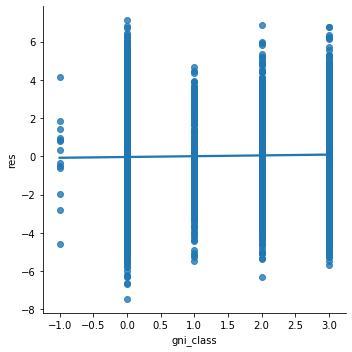

In [396]:
plot_residuals(model_views1, data, 'gni_class', False, False)

,res,gdp_pc
0,NaN,10.853739
1,-2.038382,6.854130
2,-1.967376,8.970008
3,-0.630389,7.012487
4,NaN,10.150653


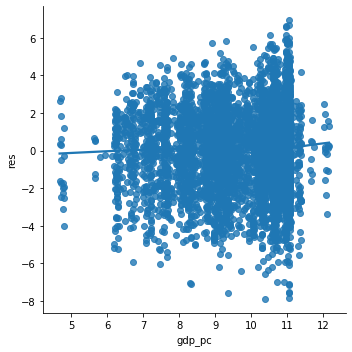

In [394]:
plot_residuals(model_views0, data, 'gdp_pc', False, False)